# Setup

In [1]:
from collections import Counter, defaultdict
from math import ceil, nan, isnan, inf, isfinite
from statistics import median, mean, pstdev
import abc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as st
import shutil
import sys

HOME = os.path.expanduser('~')

!{sys.executable} -m pip install slurmqueen -q # pypi.org/project/slurmqueen

import slurmqueen
from slurmqueen.slurm_experiment import SlurmExperiment

TIME = 1000 # paper
CTRL_TIME = 1010
SLURM_TIME = 1020 # extra time for temp files and postprocessor

MEM = 25 # paper
CTRL_MEM = 27
SLURM_MEM = 29 # extra mem for temp and post

DEPENDENCIES = ['dpmc.py', 'wrapper.py', 'postprocessor.py']

NETID = 'vhp1'

def getFilePaths(dirPaths, fileNameEnds=set(), excludedFileNameEnds=set()):
    assert isinstance(dirPaths, set), dirPaths
    assert isinstance(fileNameEnds, set), fileNameEnds
    assert isinstance(excludedFileNameEnds, set), excludedFileNameEnds
    filePaths = []
    for dirPath in dirPaths:
        dirPath = os.path.expanduser(dirPath)
        for (subdirPath, _, fileNames) in os.walk(dirPath):
            for fileName in fileNames:
                if not fileNameEnds or any(
                    [fileName.endswith(fileNameEnd) for fileNameEnd in fileNameEnds]
                ):
                    if all([not fileName.endswith(suffix) for suffix in excludedFileNameEnds]):
                        filePath = os.path.join(subdirPath, fileName)
                        filePaths.append(filePath)
    if not filePaths:
        print(f'no file with suffix {fileNameEnds} \\ {excludedFileNameEnds} in {dirPaths}')
    return sorted(filePaths)

In [2]:
class Exp(SlurmExperiment, metaclass=abc.ABCMeta):
    def initExp(self, dataPath, strictFlag):
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(strictFlag=strictFlag),
        )

    def prepare_server(self, inst): # after copying files and before submitting jobs
        files = [inst.remote_experiment_path(f) for f in DEPENDENCIES]
        cmds = [f'chmod +x {" ".join(files)}']
        for relPath in ['bin', 'benchmarks']:
            projectPath = f'/projects/vardi/{NETID}/{relPath}'
            scratchPath = inst.remote_experiment_path(relPath)
            cmds.append(f'mkdir -p {os.path.dirname(scratchPath)}')
            cmds.append(f'ln -sf {projectPath} {scratchPath}')
        cmd = ' && '.join(cmds)
        inst.server.execute(cmd)

    def getInst(self):
        return Inst(self, slurmqueen.ExperimentConfig(
            server=slurmqueen.SlurmServer('nots.rice.edu', NETID, f'{HOME}/.ssh/id_rsa'),
            partition='scavenge',
            local_directory=os.getcwd(),
            remote_directory=f'/scratch/{NETID}',
        ))

    @abc.abstractmethod
    def getWrapperDict(self):pass

    def getCmd(self, cnfFilePath):
        kwargs = dict(
            cf=cnfFilePath,
            post=1,
            memcap=CTRL_MEM,
            timecap=self.ctrlTime,
            temp='tmp',
        )
        return slurmqueen.experiment.Command('python3', 'wrapper.py', **self.getWrapperDict(), **kwargs)

    def getCmds(self):
        cmds = []
        filePaths = getFilePaths(self.cnfDirPaths)
        for i in range(len(filePaths)):
            if not self.remainingTasks or i in self.remainingTasks:
                cmds.append(self.getCmd(filePaths[i]))
        return cmds

In [3]:
def countIntDigits(num): # SlurmQueen
    return len(str(num))

def checkFile(filePath):
    if os.path.isfile(filePath):
        return True
    else:
        print(f'Missing file:\t{filePath}')
        return False

def copyFile(oldPath, newPath):
    if os.path.exists(newPath):
        raise Exception(f'Existing file: {newPath}')
    shutil.copyfile(oldPath, newPath)

def getRunScript(strictFlag, slurmMemCap=SLURM_MEM):
    script = [
        '',
        f'#SBATCH --mail-type=end',
        f'#SBATCH --mem={slurmMemCap}g',
    ]
    script += [
        '',
        '#SBATCH --constraint=ivybridge',
        '#SBATCH --exclusive',
    ] if strictFlag else []
    script += [
        '',
        'export XALT_EXECUTABLE_TRACKING=no',
        'ml load GCC/10.3.0 Python/3.9.5',
    ]
    return '\n'.join(script)

def justifyInt(num, digitCount):
    assert isinstance(num, int), num
    return str(num).rjust(digitCount, '0')

def getCeiling(iterable):
    return ceil(max(filter(isfinite, iterable)))

def printRow(key, value):
    print(key.ljust(15), end=': ')
    print(str(value).strip().rjust(5))

In [4]:
def checkTmp(inst, orderKey):
    for line in open(os.path.join(inst._exp.id, '_run.sh')):
        if line.startswith('#SBATCH --time'):
            printRow('slurm time', line.split(':')[1])
            break
    try:
        df = inst.ask(f'select tmptime,tmpmb from data order by tmp{orderKey}')
        printRow('max tmp time', getCeiling(df['tmptime']))
        printRow('max tmp MB', getCeiling(df['tmpmb']))
        return df
    except Exception as e:
        if not str(e).endswith('no such column: tmptime'):
            print(e)

def renameFiles(inst):
    newDirPath = f'{inst._exp.id}Renamed'
    os.makedirs(newDirPath)
    for i in range(len(inst._exp.remainingTasks)):
        newTask = inst._exp.remainingTasks[i]
        oldPath = os.path.join(inst._exp.id, f'slurm_{i}.worker')
        newPath = os.path.join(newDirPath, f'slurm_{newTask}.worker')
        copyFile(oldPath, newPath)
        for ext in [
#             'in',
            'log',
            'out',
        ]:
            oldDigitCount = countIntDigits(len(inst._exp.remainingTasks))
            newDigitCount = countIntDigits(len(getFilePaths(inst._exp.cnfDirPaths)))
            oldDigits = justifyInt(i, oldDigitCount)
            newDigits = justifyInt(newTask, newDigitCount)
            oldPath = os.path.join(inst._exp.id, f'{oldDigits}.{ext}')
            newPath = os.path.join(newDirPath, f'{newDigits}.{ext}')
            if ext == 'in':
                with open(newPath, 'w') as newFile:
                    for line in open(oldPath):
                        line = line.replace(f'/{oldDigits}.', f'/{newDigits}.')
                        newFile.write(line)
            else:
                copyFile(oldPath, newPath)

In [5]:
class Inst(slurmqueen.slurm_experiment.SlurmInstance):
    def ask(self, q):
        return self.query(q).convert_dtypes(convert_floating=False)

    def getDf(self, q):
        df = self.ask(q)
        return df.rename(columns={
            col: f'{col}{self._exp.tag}' for col in df.head() if col not in {
                'file', 'root', 'show', 'vars', 'clauses', 'meanlits', 'maxlits',
                'ddleaves', 'ddnodes', 'width',
            }
        })

    def runExp(self): # NOTS allows up to 5k jobs to be queued at once
        p = self._exp.id
        if os.path.exists(p):
            answer = input(f'Delete existing local dir ({p}) [Y/N]: ')
            if answer.upper() == 'Y':
                shutil.rmtree(p)
            else:
                print(f'Skipped experiment ({p})')
                return
        self.run(len(self._exp.getCmds()), f'0:{self._exp.slurmTime}')

    def checkData(self, cfFlag=True, orderKey='time'):
        cnfFilePaths = getFilePaths(self._exp.cnfDirPaths)
        for i in range(len(cnfFilePaths)):
            checkFile(os.path.join(self._exp.id, f'slurm_{i}.worker'))
            for ext in ['in', 'log', 'out']:
                filePath = os.path.join(
                    self._exp.id,
                    f'{justifyInt(i, countIntDigits(len(cnfFilePaths)))}.{ext}',
                )
                if checkFile(filePath):
                    if not os.path.getsize(filePath):
                        print(f'Empty file:\t{filePath}')
                    elif os.path.basename(cnfFilePaths[i]) not in open(filePath).readline():
                        if ext != 'log' and cfFlag:
                            print(f'Wrong cf:\t{filePath}')
        return checkTmp(self, orderKey)

# Experiments

In [6]:
CHAIN_CNF_DIR_PATHS = {'benchmarks/cnf/chain'}

APP0_CNF_DIR_PATHS = {
    'benchmarks/cnf/app0/bayes',
    'benchmarks/cnf/app0/planning',
}

RE_CNF_DIR_PATHS = {
    'benchmarks/cnf/app1re/waps',
    'benchmarks/cnf/app1re/bird',
}

ER_CNF_DIR_PATHS = {
    'benchmarks/cnf/app1er/waps',
    'benchmarks/cnf/app1er/bird',
}

def setMaxRows(rowCount=30):
    pd.set_option('display.max_rows', rowCount)

setMaxRows()

## CMS

In [7]:
class CmsExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag=False)

    def getWrapperDict(self):
        return {'prog': 'cms'}

CMS_INST = CmsExp(
    cnfDirPaths=CHAIN_CNF_DIR_PATHS | APP0_CNF_DIR_PATHS | RE_CNF_DIR_PATHS,
    dataDirPath='data/cms',
).getInst()

# CMS_INST.runExp()
# CMS_INST._gather()
CMS_INST.checkData()

slurm time     :  1020


In [8]:
q = 'select file,root,sol,time,mem from data'
q += ' order by sol,time'

CMS_INST.ask(q)

,file,root,sol,time,mem
0,907,or-70-10-10-UC-40,1,0.004627,0.000000
1,830,or-60-20-6-UC-20,1,0.005343,0.000000
2,957,or-70-20-10-UC-40,1,0.005344,0.000000
3,997,or-70-20-9-UC-40,1,0.005543,0.000000
4,611,or-50-10-2-UC-30,1,0.005564,0.000000
...,...,...,...,...,...
3175,1725,18A-4,1,7.898600,0.034580
3176,2105,xpose.sk_6_134,1,16.463300,0.057312
3177,2126,karatsuba.sk_7_41,1,20.585200,0.045496
3178,2066,logcount.sk_16_86,1,23.739700,0.071004


## R-SAT

### Planning phase

In [9]:
LG = 'lg'
HTB = 'htb'

FLOW = 'flow'
MEIJI = 'meiji'
HTD = 'htd'

class PlanExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        pt,
        td,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.pt = pt
        self.td = td
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(f'data/r/plan/{pt}{f"/{td}" if td else ""}', strictFlag)

    def getWrapperDict(self):
        d = dict(
            prog='dpmc',
            phase='plan',
            pt=self.pt,
        )
        if self.td:
            d['td'] = self.td
        return d

#### LG

In [10]:
PLAN_LF_INST = PlanExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    pt=LG,
    td=FLOW,
    strictFlag=True,
).getInst()

# PLAN_LF_INST.runExp()
# PLAN_LF_INST._gather()
PLAN_LF_INST.checkData()

slurm time     :  1020


In [11]:
q = 'select file,root,plans,width1,width,plantime1,plantime,time,mem,timeout,memout from data'
# q += ' where width not null'
q += ' order by plans'

LF_DF = PLAN_LF_INST.ask(q)
LF_DF

,file,root,plans,width1,width,plantime1,plantime,time,mem,timeout,memout
0,1050,4blocks,<NA>,<NA>,<NA>,NaN,NaN,1010.07,0.043544,1,0
1,1051,4blocksb,<NA>,<NA>,<NA>,NaN,NaN,1010.06,0.035736,1,0
2,1086,blocks_right_5_p_t10,<NA>,<NA>,<NA>,NaN,NaN,1010.05,0.092120,1,0
3,1087,blocks_right_5_p_t2,<NA>,<NA>,<NA>,NaN,NaN,1010.05,0.036224,1,0
4,1088,blocks_right_5_p_t3,<NA>,<NA>,<NA>,NaN,NaN,1010.05,0.042344,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1601,361,90-38-9-q,10,78,60,0.256460,656.538,1010.05,0.041656,1,0
1602,375,90-46-4-q,10,97,77,0.448849,148.632,1010.05,0.045724,1,0
1603,387,90-50-8-q,10,99,82,24.061600,559.232,1010.05,0.054316,1,0
1604,382,90-50-10-q,11,99,84,24.344300,921.544,1010.05,0.045064,1,0


In [12]:
LF_DF['plans'].describe()

count    1520.000000
mean        2.833553
std         1.364674
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        12.000000
Name: plans, dtype: float64

In [13]:
PLAN_LM_INST = PlanExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    pt=LG,
    td=MEIJI,
    strictFlag=True,
).getInst()

# PLAN_LM_INST.runExp()
# PLAN_LM_INST._gather()
PLAN_LM_INST.checkData()

slurm time     :  1020


In [14]:
q = 'select file,root,plans,width1,width,plantime1,plantime,time,mem,timeout,memout from data'
# q += ' where width is not null'
q += ' order by plans'

LM_DF = PLAN_LM_INST.ask(q)
LM_DF

,file,root,plans,width1,width,plantime1,plantime,time,mem,timeout,memout
0,1050,4blocks,<NA>,<NA>,<NA>,NaN,NaN,1010.14,3.497640,1,0
1,1051,4blocksb,<NA>,<NA>,<NA>,NaN,NaN,1010.17,2.631580,1,0
2,1086,blocks_right_5_p_t10,<NA>,<NA>,<NA>,NaN,NaN,1010.33,2.569764,1,0
3,1087,blocks_right_5_p_t2,<NA>,<NA>,<NA>,NaN,NaN,1010.14,1.452812,1,0
4,1088,blocks_right_5_p_t3,<NA>,<NA>,<NA>,NaN,NaN,1010.15,1.471784,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1601,1473,safe_safe_30_p_t10,29,99,71,14.25860,983.240,1010.07,1.215128,1,0
1602,1413,ring2_r8_p_t10,33,61,29,2.18961,606.929,1010.07,0.934028,1,0
1603,1545,tire-4,35,90,51,6.10371,902.354,1010.07,0.835216,1,0
1604,1480,safe_safe_30_p_t8,38,100,61,13.29280,1001.220,1010.13,1.116056,1,0


In [15]:
LM_DF['plans'].describe()

count    1544.000000
mean        6.150259
std         5.030892
min         1.000000
25%         3.000000
50%         4.000000
75%         9.000000
max        45.000000
Name: plans, dtype: float64

In [16]:
PLAN_LH_INST = PlanExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    pt=LG,
    td=HTD,
    strictFlag=True,
).getInst()

# PLAN_LH_INST.runExp()
# PLAN_LH_INST._gather()
PLAN_LH_INST.checkData()

slurm time     :  1020


In [17]:
q = 'select file,root,plans,width1,width,plantime1,plantime,time,mem,timeout,memout from data'
# q += ' where width is not null'
q += ' order by plans'

LH_DF = PLAN_LH_INST.ask(q)
LH_DF

,file,root,plans,width1,width,plantime1,plantime,time,mem,timeout,memout
0,1086,blocks_right_5_p_t10,<NA>,<NA>,<NA>,NaN,NaN,1010.05,0.057752,1,0
1,1087,blocks_right_5_p_t2,<NA>,<NA>,<NA>,NaN,NaN,1010.05,0.037844,1,0
2,1088,blocks_right_5_p_t3,<NA>,<NA>,<NA>,NaN,NaN,1010.05,0.038724,1,0
3,1089,blocks_right_5_p_t4,<NA>,<NA>,<NA>,NaN,NaN,1010.05,0.042816,1,0
4,1090,blocks_right_5_p_t5,<NA>,<NA>,<NA>,NaN,NaN,1010.05,0.045524,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1601,344,90-34-10-q,12,68,37,0.138305,65.3619,1010.05,0.053968,1,0
1602,345,90-34-2-q,12,68,36,0.167300,338.2840,1010.05,0.060200,1,0
1603,367,90-42-5-q,12,87,46,0.191102,231.8840,1010.06,0.069868,1,0
1604,343,90-34-1-q,13,68,36,0.142535,780.7930,1010.05,0.055376,1,0


In [18]:
LH_DF['plans'].describe()

count    1538.000000
mean        3.268531
std         1.833700
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        13.000000
Name: plans, dtype: float64

#### HTB

In [19]:
PLAN_H_INST = PlanExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    pt=HTB,
    td='',
    strictFlag=True,
).getInst()

# PLAN_H_INST.runExp()
# PLAN_H_INST._gather()
PLAN_H_INST.checkData()

slurm time     :  1020


In [20]:
q = 'select file,root,width,time,mem,timeout,memout from data'
q += ' where width is not null'
q += ' order by width'

PLAN_H_INST.ask(q)

,file,root,width,time,mem,timeout,memout
0,1361,flip_1_p_t1,4,0.088005,0.000000,0,0
1,1362,flip_1_p_t10,4,0.090325,0.000000,0,0
2,1363,flip_1_p_t2,4,0.078205,0.000000,0,0
3,1364,flip_1_p_t3,4,0.085253,0.000000,0,0
4,1367,flip_1_p_t6,4,0.083197,0.000000,0,0
...,...,...,...,...,...,...,...
1426,1391,logistics.c,356,623.759000,0.033716,0,0
1427,1598,uts_k5_p_t2,360,413.425000,0.026552,0,0
1428,1526,sort_num_s_6_p_t4,408,985.034000,0.027352,0,0
1429,1590,uts_k4_p_t4,489,796.830000,0.030392,0,0


### Execution phase

In [21]:
def getParentDirPaths(filePaths):
    return sorted(set(map(os.path.dirname, filePaths)))

def printExecRow(k, v, td):
    print(str(k).rjust(5), v.ljust(8), '|', td if td else HTB)

def getJtFilePaths(td, roots=[]):
    filePaths = []
    for dirPath in getParentDirPaths(getFilePaths({f'benchmarks/jt/{f"{LG}/{td}" if td else HTB}'})):
        if not roots or any(map(dirPath.endswith, roots)):
            jtPaths = getFilePaths({dirPath})
            jtCount = len(jtPaths)
            if jtCount in range(2, 10) or not td:
                filePaths.extend(jtPaths)
    printExecRow(len(filePaths), 'PJTs', td)
    return filePaths

def getRoots(td):
    roots = set()
    for dirPath in getParentDirPaths(getJtFilePaths(td)):
        roots.add(os.path.join(os.path.basename(os.path.dirname(dirPath)), os.path.basename(dirPath)))
#     printExecRow(len(roots), 'formulas', td)
    return roots

EXEC_CNF_ROOTS = sorted(set.intersection(*map(getRoots, [FLOW, MEIJI, HTD, ''])))
print(len(EXEC_CNF_ROOTS), 'common formulas')

getJtFilePaths(FLOW, EXEC_CNF_ROOTS)
getJtFilePaths(MEIJI, EXEC_CNF_ROOTS)
getJtFilePaths(HTD, EXEC_CNF_ROOTS)
getJtFilePaths('', EXEC_CNF_ROOTS)

DMC = 'dmc'
TENSOR = 'tensor'

def getDpmcTag(et, pt, td='', tw=100):
    tdTag = td[0].upper() if td else ''
    return f'Dp{et[0].upper()}{pt[0].upper()}{tdTag}{"" if tw == 100 else tw}'

 2912 PJTs     | flow
 4628 PJTs     | meiji
 3994 PJTs     | htd
 1431 PJTs     | htb
627 common formulas
 1412 PJTs     | flow
 2836 PJTs     | meiji
 1690 PJTs     | htd
  627 PJTs     | htb


In [22]:
class ExecExp(Exp):
    def __init__(
        self,
        et,
        pt,
        td,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.et = et
        self.pt = pt
        self.td = td
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(f'data/r/exec/{et}/{pt}{f"/{td}" if td else ""}', strictFlag)
        self.tag = getDpmcTag(et, pt, td)

    def getWrapperDict(self):
        d = dict(
            prog='dpmc',
            phase='exec',
            et=self.et,
            pt=self.pt,
        )
        return d | {'td': self.td} if self.td else d

    def getCmd(self, jtFilePath):
        kwargs = dict(
            cf=f'{os.path.dirname(jtFilePath)}.cnf'.replace(
                f'jt/{f"{LG}/{self.td}" if self.td else HTB}', 'cnf/app0'
            ),
            jf=jtFilePath,
            post=1,
            memcap=CTRL_MEM,
            timecap=self.ctrlTime,
        )
        return slurmqueen.experiment.Command('python3', 'wrapper.py', **self.getWrapperDict(), **kwargs)

    def getCmds(self):
        cmds = []
        filePaths = getJtFilePaths(self.td, EXEC_CNF_ROOTS)
        for i in range(len(filePaths)):
            if not self.remainingTasks or i in self.remainingTasks:
                cmds.append(self.getCmd(filePaths[i]))
        return cmds

#### DMC

In [23]:
EXEC_DLF_INST = ExecExp(
    et=DMC,
    pt=LG,
    td=FLOW,
    strictFlag=True,
).getInst()

# EXEC_DLF_INST.runExp()
# EXEC_DLF_INST._gather()

 1412 PJTs     | flow


In [24]:
q = 'select file,root,logsol,width,plantime,exectime,time,mem,timeout,memout from data'
q += ' where logsol is not null'
q += ' order by root'

EXEC_DLF_INST.ask(q)

,file,root,logsol,width,plantime,exectime,time,mem,timeout,memout
0,0,50-10-1-q,-0.275595,16,0.019304,4.457690,4.476994,0.011188,0,0
1,1,50-10-1-q,-0.275595,14,0.075120,5.226210,5.301330,0.011192,0,0
2,2,50-10-10-q,-0.038721,17,0.018926,4.689860,4.708786,0.007640,0,0
3,3,50-10-10-q,-0.038721,15,0.071320,0.439465,0.510785,0.007640,0,0
4,4,50-10-10-q,-0.038721,14,96.307300,5.229330,101.536630,0.011192,0,0
...,...,...,...,...,...,...,...,...,...,...
1359,1397,uts_k2_p_t3,-97.777700,42,0.526184,22.895600,23.421784,0.255280,0,0
1360,1398,uts_k2_p_t5,-170.805000,51,0.049618,687.315000,687.364618,2.892624,0,0
1361,1399,uts_k2_p_t5,-170.805000,43,1.065810,10.128900,11.194710,0.218296,0,0
1362,1403,uts_k2_p_t7,-223.580000,47,1.689140,16.508800,18.197940,0.260260,0,0


In [25]:
EXEC_DLM_INST = ExecExp(
    et=DMC,
    pt=LG,
    td=MEIJI,
    strictFlag=True,
).getInst()

# EXEC_DLM_INST.runExp()
# EXEC_DLM_INST._gather()

 2836 PJTs     | meiji


In [26]:
q = 'select file,root,logsol,width,plantime,exectime,time,mem,timeout,memout from data'
q += ' where logsol is not null'
q += ' order by root'

EXEC_DLM_INST.ask(q)

,file,root,logsol,width,plantime,exectime,time,mem,timeout,memout
0,1,50-10-1-q,-0.275595,14,0.556048,0.158980,0.715028,0.026620,0,0
1,2,50-10-1-q,-0.275595,13,1.239300,0.166585,1.405885,0.026624,0,0
2,3,50-10-1-q,-0.275595,12,2.151150,0.204924,2.356074,0.012348,0,0
3,4,50-10-1-q,-0.275595,11,3.184190,0.168645,3.352835,0.024780,0,0
4,6,50-10-10-q,-0.038721,14,0.524172,0.207395,0.731567,0.012352,0,0
...,...,...,...,...,...,...,...,...,...,...
2685,2811,uts_k3_p_t2,-146.763000,77,9.006150,313.954000,322.960150,1.339516,0,0
2686,2813,uts_k3_p_t2,-146.763000,74,22.850200,417.206000,440.056200,1.553548,0,0
2687,2814,uts_k3_p_t2,-146.763000,73,34.060700,111.764000,145.824700,0.752956,0,0
2688,2815,uts_k3_p_t2,-146.763000,72,51.507700,464.011000,515.518700,1.644412,0,0


In [27]:
EXEC_DLH_INST = ExecExp(
    et=DMC,
    pt=LG,
    td=HTD,
    strictFlag=True,
).getInst()

# EXEC_DLH_INST.runExp()
# EXEC_DLH_INST._gather()

 1690 PJTs     | htd


In [28]:
q = 'select file,root,logsol,width,plantime,exectime,time,mem,timeout,memout from data'
q += ' where logsol is not null'
q += ' order by root'

EXEC_DLH_INST.ask(q)

,file,root,logsol,width,plantime,exectime,time,mem,timeout,memout
0,0,50-10-1-q,-0.275595,16,0.041861,0.125495,0.167356,0.000000,0,0
1,1,50-10-1-q,-0.275595,15,0.044533,0.114952,0.159485,0.000000,0,0
2,2,50-10-1-q,-0.275595,12,0.050734,0.152581,0.203315,0.029724,0,0
3,3,50-10-10-q,-0.038721,16,0.040385,0.131078,0.171463,0.000000,0,0
4,4,50-10-10-q,-0.038721,15,0.042953,0.110780,0.153733,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...
1570,1672,uts_k2_p_t3,-97.777700,45,0.043599,3.184080,3.227679,0.145724,0,0
1571,1673,uts_k2_p_t3,-97.777700,41,0.052297,1.688710,1.741007,0.099608,0,0
1572,1674,uts_k2_p_t5,-170.805000,45,0.050387,11.624900,11.675287,0.253340,0,0
1573,1675,uts_k2_p_t5,-170.805000,42,0.066079,10.977600,11.043680,0.246596,0,0


In [29]:
EXEC_DH_INST = ExecExp(
    et=DMC,
    pt=HTB,
    td='',
    strictFlag=True,
).getInst()

# EXEC_DH_INST.runExp()
# EXEC_DH_INST._gather()

  627 PJTs     | htb


In [30]:
q = 'select file,root,logsol,width,plantime,exectime,time,mem,timeout,memout from data'
q += ' where logsol is not null'
q += ' order by root'

EXEC_DH_INST.ask(q)

,file,root,logsol,width,plantime,exectime,time,mem,timeout,memout
0,0,50-10-1-q,-0.275595,18,2.128,1.530470,3.658470,0.110516,0,0
1,1,50-10-10-q,-0.038721,13,1.450,0.113591,1.563591,0.000000,0,0
2,2,50-10-2-q,-0.158469,23,2.576,67.053800,69.629800,0.470984,0,0
3,3,50-10-3-q,-0.359167,16,2.100,0.443179,2.543179,0.040232,0,0
4,4,50-10-4-q,-0.213528,20,1.806,1.732950,3.538950,0.115292,0,0
...,...,...,...,...,...,...,...,...,...,...
546,611,safe_safe_5_p_t9,-35.601100,21,0.342,0.129172,0.471172,0.025836,0,0
547,616,uts_k1_p_t3,-28.559300,29,0.222,0.118969,0.340969,0.000000,0,0
548,617,uts_k2_p_t1,-33.788900,48,0.424,0.207895,0.631895,0.029004,0,0
549,618,uts_k2_p_t2,-64.779600,76,2.565,368.305000,370.870000,0.951972,0,0


#### Tensor

In [31]:
EXEC_TLF_INST = ExecExp(
    et=TENSOR,
    pt=LG,
    td=FLOW,
    strictFlag=True,
).getInst()

# EXEC_TLF_INST.runExp()
# EXEC_TLF_INST._gather()

 1412 PJTs     | flow


In [32]:
q = 'select file,root,logsol,width,plantime,exectime,time,mem,timeout,memout from data'
q += ' where logsol is not null'
q += ' order by root'

EXEC_TLF_INST.ask(q)

,file,root,logsol,width,plantime,exectime,time,mem,timeout,memout
0,0,50-10-1-q,-0.273246,16,0.019304,0.820256,0.839560,0.052256,0,0
1,1,50-10-1-q,-0.273246,14,0.075120,0.704492,0.779612,0.051740,0,0
2,2,50-10-10-q,-0.476468,17,0.018926,0.737836,0.756762,0.130036,0,0
3,3,50-10-10-q,-0.476468,15,0.071320,0.735002,0.806322,0.134484,0,0
4,4,50-10-10-q,-0.476468,15,96.307300,0.705529,97.012829,0.052204,0,0
...,...,...,...,...,...,...,...,...,...,...
756,1381,safe_safe_5_p_t9,-33.751904,10,0.026553,0.658539,0.685092,0.050392,0,0
757,1390,uts_k1_p_t3,-29.016004,20,0.014764,0.726069,0.740833,0.121656,0,0
758,1391,uts_k1_p_t3,-29.016004,16,0.025978,0.724863,0.750841,0.050628,0,0
759,1392,uts_k2_p_t1,-37.123973,29,0.017215,75.309200,75.326415,13.085420,0,0


In [33]:
EXEC_TLM_INST = ExecExp(
    et=TENSOR,
    pt=LG,
    td=MEIJI,
    strictFlag=True,
).getInst()

# EXEC_TLM_INST.runExp()
# EXEC_TLM_INST._gather()

 2836 PJTs     | meiji


In [34]:
q = 'select file,root,logsol,width,plantime,exectime,time,mem,timeout,memout from data'
q += ' where logsol is not null'
q += ' order by root'

EXEC_TLM_INST.ask(q)

,file,root,logsol,width,plantime,exectime,time,mem,timeout,memout
0,1,50-10-1-q,-0.273246,14,0.556048,0.751384,1.307432,0.052440,0,0
1,2,50-10-1-q,-0.273246,13,1.239300,0.773881,2.013181,0.050152,0,0
2,3,50-10-1-q,-0.273246,12,2.151150,0.781045,2.932195,0.052096,0,0
3,4,50-10-1-q,-0.273246,11,3.184190,0.774358,3.958548,0.052208,0,0
4,6,50-10-10-q,-0.476468,14,0.524172,0.738201,1.262373,0.050604,0,0
...,...,...,...,...,...,...,...,...,...,...
1353,2756,safe_safe_5_p_t8,-29.070184,11,0.532200,0.671964,1.204164,0.052988,0,0
1354,2757,safe_safe_5_p_t8,-29.070184,11,0.745864,0.683609,1.429473,0.052764,0,0
1355,2759,safe_safe_5_p_t9,-33.751904,11,0.457837,0.692020,1.149857,0.052160,0,0
1356,2788,uts_k1_p_t3,-29.016004,16,0.492867,0.798263,1.291130,0.048604,0,0


In [35]:
EXEC_TLH_INST = ExecExp(
    et=TENSOR,
    pt=LG,
    td=HTD,
    strictFlag=True,
).getInst()

# EXEC_TLH_INST.runExp()
# EXEC_TLH_INST._gather()

 1690 PJTs     | htd


In [36]:
q = 'select file,root,logsol,width,plantime,exectime,time,mem,timeout,memout from data'
q += ' where logsol is not null'
q += ' order by root'

EXEC_TLH_INST.ask(q)

,file,root,logsol,width,plantime,exectime,time,mem,timeout,memout
0,0,50-10-1-q,-0.273246,16,0.041861,0.689929,0.731790,0.048236,0,0
1,1,50-10-1-q,-0.273246,15,0.044533,0.776142,0.820675,0.052408,0,0
2,2,50-10-1-q,-0.273246,12,0.050734,0.733217,0.783951,0.050436,0,0
3,3,50-10-10-q,-0.476468,16,0.040385,0.726551,0.766936,0.052300,0,0
4,4,50-10-10-q,-0.476468,15,0.042953,0.756906,0.799859,0.052620,0,0
...,...,...,...,...,...,...,...,...,...,...
796,1656,safe_safe_5_p_t9,-33.751904,11,0.119175,0.720784,0.839959,0.050388,0,0
797,1657,safe_safe_5_p_t9,-33.751904,11,821.386000,0.719534,822.105534,0.052504,0,0
798,1666,uts_k1_p_t3,-29.016004,17,0.038590,0.763290,0.801880,0.128136,0,0
799,1667,uts_k1_p_t3,-29.016004,16,0.039563,0.741384,0.780947,0.060036,0,0


In [37]:
EXEC_TH_INST = ExecExp(
    et=TENSOR,
    pt=HTB,
    td='',
    strictFlag=True,
).getInst()

# EXEC_TH_INST.runExp()
# EXEC_TH_INST._gather()

  627 PJTs     | htb


In [38]:
q = 'select file,root,logsol,width,plantime,exectime,time,mem,timeout,memout from data'
q += ' where logsol is not null'
q += ' order by root'

EXEC_TH_INST.ask(q)

,file,root,logsol,width,plantime,exectime,time,mem,timeout,memout
0,0,50-10-1-q,-0.273246,18,2.128,1.027340,3.155340,0.129100,0,0
1,1,50-10-10-q,-0.476468,13,1.450,0.749585,2.199585,0.050692,0,0
2,2,50-10-2-q,-0.373798,23,2.576,4.061470,6.637470,0.562876,0,0
3,3,50-10-3-q,-0.291058,16,2.100,0.759578,2.859578,0.063520,0,0
4,4,50-10-4-q,-0.229429,20,1.806,0.985806,2.791806,0.266452,0,0
...,...,...,...,...,...,...,...,...,...,...
126,608,safe_safe_5_p_t6,-21.005108,23,0.112,1.126290,1.238290,0.510080,0,0
127,609,safe_safe_5_p_t7,-28.072619,21,0.168,0.772432,0.940432,0.087528,0,0
128,610,safe_safe_5_p_t8,-29.070184,23,0.257,2.120790,2.377790,0.469232,0,0
129,611,safe_safe_5_p_t9,-33.751904,21,0.342,0.931697,1.273697,0.189620,0,0


### Dual phase

#### DPMC

In [39]:
def getDataDirPath(et, pt, td, tw):
    tdDirPath = td if td == HTD else f'{td}{"" if tw == 100 else tw}'
    return f'data/r/dual/dpmc/{et}/{pt}{"" if pt == HTB else f"/{tdDirPath}"}'

class DpmcExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        et,
        pt,
        td,
        tw,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.et = et
        self.pt = pt
        self.td = td
        self.tw = tw
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(getDataDirPath(et, pt, td, tw), strictFlag)
        self.tag = getDpmcTag(et, pt, td, tw)

    def getWrapperDict(self):
        d = dict(prog='dpmc', et=self.et, pt=self.pt)
        return d | dict(td=self.td, tw=self.tw) if self.td else d

DP_DLF = getDpmcTag(et=DMC, pt=LG, td=FLOW)
DP_DLF80 = getDpmcTag(et=DMC, pt=LG, td=FLOW, tw=80)
DP_DLF60 = getDpmcTag(et=DMC, pt=LG, td=FLOW, tw=60)
DP_DLF40 = getDpmcTag(et=DMC, pt=LG, td=FLOW, tw=40)
DP_DLM = getDpmcTag(et=DMC, pt=LG, td=MEIJI)
DP_DLM80 = getDpmcTag(et=DMC, pt=LG, td=MEIJI, tw=80)
DP_DLM60 = getDpmcTag(et=DMC, pt=LG, td=MEIJI, tw=60)
DP_DLM40 = getDpmcTag(et=DMC, pt=LG, td=MEIJI, tw=40)
DP_DLH = getDpmcTag(et=DMC, pt=LG, td=HTD)
DP_DH = getDpmcTag(et=DMC, pt=HTB)

DP_TLF = getDpmcTag(et=TENSOR, pt=LG, td=FLOW)
DP_TLM = getDpmcTag(et=TENSOR, pt=LG, td=MEIJI)
DP_TLH = getDpmcTag(et=TENSOR, pt=LG, td=HTD)
DP_TH = getDpmcTag(et=TENSOR, pt=HTB)

##### DMC

In [40]:
DP_DLF_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=DMC,
    pt=LG,
    td=FLOW,
    tw=100,
    strictFlag=True,
).getInst()

# DP_DLF_INST.runExp()
# DP_DLF_INST._gather()
DP_DLF_INST.checkData()

slurm time     :  1020


In [41]:
DP_DLF80_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=DMC,
    pt=LG,
    td=FLOW,
    tw=80,
    strictFlag=True,
).getInst()

# DP_DLF80_INST.runExp()
# DP_DLF80_INST._gather()
DP_DLF80_INST.checkData()

slurm time     :  1020


In [42]:
DP_DLF60_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=DMC,
    pt=LG,
    td=FLOW,
    tw=60,
    strictFlag=True,
).getInst()

# DP_DLF60_INST.runExp()
# DP_DLF60_INST._gather()
DP_DLF60_INST.checkData()

slurm time     :  1020


In [43]:
DP_DLF40_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=DMC,
    pt=LG,
    td=FLOW,
    tw=40,
    strictFlag=True,
).getInst()

# DP_DLF40_INST.runExp()
# DP_DLF40_INST._gather()
DP_DLF40_INST.checkData()

slurm time     :  1020


In [44]:
DP_DLM_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=DMC,
    pt=LG,
    td=MEIJI,
    tw=100,
    strictFlag=True,
).getInst()

# DP_DLM_INST.runExp()
# DP_DLM_INST._gather()
DP_DLM_INST.checkData()

slurm time     :  1020


In [45]:
DP_DLM80_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=DMC,
    pt=LG,
    td=MEIJI,
    tw=80,
    strictFlag=True,
).getInst()

# DP_DLM80_INST.runExp()
# DP_DLM80_INST._gather()
DP_DLM80_INST.checkData()

slurm time     :  1020


In [46]:
DP_DLM60_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=DMC,
    pt=LG,
    td=MEIJI,
    tw=60,
    strictFlag=True,
).getInst()

# DP_DLM60_INST.runExp()
# DP_DLM60_INST._gather()
DP_DLM60_INST.checkData()

slurm time     :  1020


In [47]:
DP_DLM40_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=DMC,
    pt=LG,
    td=MEIJI,
    tw=40,
    strictFlag=True,
).getInst()

# DP_DLM40_INST.runExp()
# DP_DLM40_INST._gather()
DP_DLM40_INST.checkData()

slurm time     :  1020


In [48]:
DP_DLH_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=DMC,
    pt=LG,
    td=HTD,
    tw=100,
    strictFlag=True,
).getInst()

# DP_DLH_INST.runExp()
# DP_DLH_INST._gather()
DP_DLH_INST.checkData()

slurm time     :  1020


In [49]:
DP_DH_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=DMC,
    pt=HTB,
    td='',
    tw=100,
    strictFlag=True,
).getInst()

# DP_DH_INST.runExp()
# DP_DH_INST._gather()
DP_DH_INST.checkData()

slurm time     :  1020


##### Tensor

In [50]:
DP_TLF_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=TENSOR,
    pt=LG,
    td=FLOW,
    tw=100,
    strictFlag=True,
).getInst()

# DP_TLF_INST.runExp()
# DP_TLF_INST._gather()
DP_TLF_INST.checkData()

slurm time     :  1020


In [51]:
DP_TLM_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=TENSOR,
    pt=LG,
    td=MEIJI,
    tw=100,
    strictFlag=True,
).getInst()

# DP_TLM_INST.runExp()
# DP_TLM_INST._gather()
DP_TLM_INST.checkData()

slurm time     :  1020


In [52]:
DP_TLH_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=TENSOR,
    pt=LG,
    td=HTD,
    tw=100,
    strictFlag=True,
).getInst()

# DP_TLH_INST.runExp()
# DP_TLH_INST._gather()
DP_TLH_INST.checkData()

slurm time     :  1020


In [53]:
DP_TH_INST = DpmcExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    et=TENSOR,
    pt=HTB,
    td='',
    tw=100,
    strictFlag=True,
).getInst()

# DP_TH_INST.runExp()
# DP_TH_INST._gather()
DP_TH_INST.checkData()

slurm time     :  1020


#### Other solvers

##### Cachet

In [54]:
class CachetExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = CAC

    def getWrapperDict(self):
        return {'prog': 'cachet'}

CAC = 'Cac'

CAC_INST = CachetExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    dataDirPath='data/r/dual/cachet',
    strictFlag=True,
).getInst()

# CAC_INST.runExp()
# CAC_INST._gather()
CAC_INST.checkData()

slurm time     :  1020


##### C2D

In [55]:
C2D = 'C2d'

class C2dExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = C2D

    def getWrapperDict(self):
        return {'prog': 'c2d'}

C2D_INST = C2dExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    dataDirPath='data/r/dual/c2d',
    strictFlag=True,
).getInst()

# C2D_INST.runExp()
# C2D_INST._gather()
C2D_INST.checkData()

slurm time     :  1020


##### miniC2D

In [56]:
MINI = 'Mini'

class Minic2dExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = MINI

    def getWrapperDict(self):
        return {'prog': 'mini'}

MINI_INST = Minic2dExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    dataDirPath='data/r/dual/minic2d',
    strictFlag=True,
).getInst()

In [57]:
# MINI_INST.runExp()
# MINI_INST._gather()
MINI_INST.checkData()

slurm time     :  1020
max tmp time   :     3
max tmp MB     :     4


,tmptime,tmpmb
0,0.002949,0.000662
1,0.002980,0.000528
2,0.003369,0.000327
3,0.003412,0.000347
4,0.003594,0.001080
...,...,...
1601,1.278742,2.225413
1602,1.421741,2.557307
1603,1.453983,2.317095
1604,1.604983,2.889426


##### D4

In [58]:
class D4Exp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = D4

    def getWrapperDict(self):
        return dict(prog='d4')

D4 = 'D4'

D4_INST = D4Exp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    dataDirPath='data/r/dual/d4',
    strictFlag=True,
).getInst()

# D4_INST.runExp()
# D4_INST._gather()
D4_INST.checkData()

slurm time     :  1020


## E-SAT

### DPO

In [59]:
DPO = 'Dpo'

class DpoExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = DPO

    def getWrapperDict(self):
        return dict(
            prog='dpmc',
            er=1,
        )

APP_DPO_INST = DpoExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    dataDirPath='data/e/app0/dpo',
    strictFlag=True,
).getInst()

# APP_DPO_INST.runExp()
# APP_DPO_INST._gather()
APP_DPO_INST.checkData()

slurm time     :  1020


In [60]:
CHAIN_DPO_INST = DpoExp(
    cnfDirPaths=CHAIN_CNF_DIR_PATHS,
    dataDirPath='data/e/chain/dpo',
    strictFlag=True,
).getInst()

# CHAIN_DPO_INST.runExp()
# CHAIN_DPO_INST._gather()
CHAIN_DPO_INST.checkData()

slurm time     :  1020


### Gauss

In [61]:
GAU = 'Gau'

class GaussExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME * 2,
        slurmTime=SLURM_TIME * 2,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = GAU

    def getWrapperDict(self):
        return {'prog': 'gauss'}

In [62]:
APP_GAU_INST = GaussExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    dataDirPath='data/e/app0/gauss',
    strictFlag=True,
).getInst()

# APP_GAU_INST.runExp()
# APP_GAU_INST._gather()
APP_GAU_INST.checkData()

slurm time     :  2040
max tmp time   :  1927
max tmp MB     :     5


,tmptime,tmpmb
0,0.003220,0.000392
1,0.004850,0.000988
2,0.006090,0.001608
3,0.006177,0.001481
4,0.007529,0.001766
...,...,...
1601,977.217825,2.693496
1602,1051.478923,1.698293
1603,1171.738063,4.252153
1604,1424.762032,4.736032


In [63]:
CHAIN_GAU_INST = GaussExp(
    cnfDirPaths=CHAIN_CNF_DIR_PATHS,
    dataDirPath='data/e/chain/gauss',
    strictFlag=True,
).getInst()

# CHAIN_GAU_INST.runExp()
# CHAIN_GAU_INST._gather()
CHAIN_GAU_INST.checkData()

slurm time     :  2040
max tmp time   :    54
max tmp MB     :     2


,tmptime,tmpmb
0,3.077050,0.079367
1,3.111082,0.205862
2,3.113525,0.112792
3,3.126184,0.214971
4,3.142532,0.093746
...,...,...
956,52.606909,0.861439
957,52.703178,0.884011
958,53.129397,1.019233
959,53.215581,0.906573


### MaxHS

In [64]:
MAX = 'Max'

class MaxhsExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME * 2,
        slurmTime=SLURM_TIME * 2,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = MAX

    def getWrapperDict(self):
        return {'prog': 'maxhs'}

In [65]:
APP_MAX_INST = MaxhsExp(
    cnfDirPaths=APP0_CNF_DIR_PATHS,
    dataDirPath='data/e/app0/maxhs',
    strictFlag=True,
).getInst()

# APP_MAX_INST.runExp()
# APP_MAX_INST._gather()
APP_MAX_INST.checkData()

slurm time     :  2040
max tmp time   :  1902
max tmp MB     :     5


,tmptime,tmpmb
0,0.003900,0.000635
1,0.004343,0.001298
2,0.004606,0.000988
3,0.004939,0.001194
4,0.005310,0.000680
...,...,...
1601,951.192290,3.768012
1602,1025.513169,1.698293
1603,1202.329587,4.252153
1604,1478.898654,4.736032


In [66]:
CHAIN_MAX_INST = MaxhsExp(
    cnfDirPaths=CHAIN_CNF_DIR_PATHS,
    dataDirPath='data/e/chain/maxhs',
    strictFlag=True,
).getInst()

# CHAIN_MAX_INST.runExp()
# CHAIN_MAX_INST._gather()
CHAIN_MAX_INST.checkData()

slurm time     :  2040
max tmp time   :  2066
max tmp MB     :   113


,tmptime,tmpmb
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
956,2031.594538,112.649368
957,2048.219467,84.018466
958,2048.727161,62.992262
959,2060.701409,93.330976


### UWr

In [67]:
UWR = 'Uwr'

class UwrExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME * 2,
        slurmTime=SLURM_TIME * 2,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = UWR

    def getWrapperDict(self):
        return {'prog': 'uwr'}

In [68]:
CHAIN_UWR_INST = UwrExp(
    cnfDirPaths=CHAIN_CNF_DIR_PATHS,
    dataDirPath='data/e/chain/uwr',
    strictFlag=True,
).getInst()

# CHAIN_UWR_INST.runExp()
# CHAIN_UWR_INST._gather()
CHAIN_UWR_INST.checkData()

slurm time     :  2040
max tmp time   :  2050
max tmp MB     :   113


,tmptime,tmpmb
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
956,2025.584395,105.217354
957,2027.498922,60.192823
958,2031.229719,93.330976
959,2035.810995,69.295892


## RE-SAT

### DPRE

In [69]:
DPRE = 'Dpre'

class DpreExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = DPRE

    def getWrapperDict(self):
        return dict(
            prog='dpmc',
            pc=1,
        )

DPRE_INST = DpreExp(
    cnfDirPaths=RE_CNF_DIR_PATHS,
    dataDirPath='data/re/dpre',
    strictFlag=True,
).getInst()

# DPRE_INST.runExp()
# DPRE_INST._gather()
DPRE_INST.checkData()

slurm time     :  2000


### D4P

In [70]:
D4P = 'D4p'

class D4pExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = D4P

    def getWrapperDict(self):
        return dict(prog='d4p')

D4P_INST = D4pExp(
    cnfDirPaths=RE_CNF_DIR_PATHS,
    dataDirPath='data/re/d4p',
    strictFlag=True,
).getInst()

# D4P_INST.runExp()
# D4P_INST._gather()
D4P_INST.checkData()

slurm time     :  2000


### projMC

In [71]:
PROJ = 'Proj'

class ProjmcExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = PROJ

    def getWrapperDict(self):
        return dict(prog='projmc')

PROJ_INST = ProjmcExp(
    cnfDirPaths=RE_CNF_DIR_PATHS,
    dataDirPath='data/re/projmc',
    strictFlag=True,
).getInst()

# PROJ_INST.runExp()
# PROJ_INST._gather()
PROJ_INST.checkData()

slurm time     :  2000


### reSSAT

In [72]:
RESS = 'Ress'

class RessatExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = RESS

    def getWrapperDict(self):
        return {'prog': 'ressat'}

In [73]:
RESS_INST = RessatExp(
    cnfDirPaths=RE_CNF_DIR_PATHS,
    dataDirPath='data/re/ressat',
    strictFlag=True,
).getInst()

# RESS_INST.runExp()
# RESS_INST._gather()
RESS_INST.checkData()

slurm time     :  2000
max tmp time   :     3
max tmp MB     :     8


,tmptime,tmpmb
0,0.002966,0.000646
1,0.003199,0.000763
2,0.003646,0.001079
3,0.003737,0.000550
4,0.003781,0.000787
...,...,...
608,2.859754,7.231855
609,2.881054,7.524251
610,2.883471,7.524251
611,2.897669,5.863554


## ER-SAT

### DPER

In [74]:
DPER = 'Dper'

class DperExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = DPER

    def getWrapperDict(self):
        return dict(
            prog='dpmc',
            pc=1,
            er=1,
        )

DPER_INST = DperExp(
    cnfDirPaths=ER_CNF_DIR_PATHS,
    dataDirPath='data/er/dper',
    strictFlag=True,
).getInst()

# DPER_INST.runExp()
# DPER_INST._gather()
DPER_INST.checkData()

slurm time     :  2000


### erSSAT

In [75]:
ERSS = 'Erss'

class ErssatExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = ERSS

    def getWrapperDict(self):
        return {'prog': 'erssat'}

In [76]:
ERSS_INST = ErssatExp(
    cnfDirPaths=ER_CNF_DIR_PATHS,
    dataDirPath='data/er/erssat',
    strictFlag=True,
).getInst()

# ERSS_INST.runExp()
# ERSS_INST._gather()
ERSS_INST.checkData()

slurm time     :  2000
max tmp time   :     4
max tmp MB     :     8


,tmptime,tmpmb
0,0.003384,0.000763
1,0.003439,0.000646
2,0.003646,0.000716
3,0.003880,0.000550
4,0.003892,0.000716
...,...,...
608,2.869173,7.414170
609,2.905459,5.863554
610,2.915167,5.783729
611,3.091571,7.524251


### DC-SSAT

In [77]:
DCSS = 'Dcss'

class DcssatExp(Exp):
    def __init__(
        self,
        cnfDirPaths,
        dataDirPath,
        strictFlag,
        ctrlTime=CTRL_TIME,
        slurmTime=SLURM_TIME,
        remainingTasks=[],
    ):
        self.cnfDirPaths = cnfDirPaths
        self.ctrlTime = ctrlTime
        self.slurmTime = slurmTime
        self.remainingTasks = remainingTasks
        self.initExp(dataDirPath, strictFlag)
        self.tag = DCSS

    def getWrapperDict(self):
        return {'prog': 'dcssat'}

In [78]:
DCSS_INST = DcssatExp(
    cnfDirPaths=ER_CNF_DIR_PATHS,
    dataDirPath='data/er/dcssat',
    strictFlag=True,
).getInst()

# DCSS_INST.runExp()
# DCSS_INST._gather()
DCSS_INST.checkData()

slurm time     :  2000
max tmp time   :     4
max tmp MB     :     8


,tmptime,tmpmb
0,0.003385,0.000644
1,0.005002,0.001788
2,0.005070,0.000716
3,0.005320,0.001788
4,0.005898,0.004162
...,...,...
608,3.077612,6.956909
609,3.128367,6.956877
610,3.155926,7.414170
611,3.511599,7.524251


# Correctness

In [79]:
class Table(pd.DataFrame):
    def setFields(self, refTag, maxDiff, maxTime, maxMem):
        self.refTag = refTag
        self.maxDiff = maxDiff
        self.maxTime = maxTime
        self.maxMem = maxMem

    def getTags(self):
        tags = []
        for col in self.columns:
            if col.startswith('mem'):
                tags.append(col[3:])
        return tags

    def getRows(self):
        return [pair[1] for pair in self.iterrows()]

def getTable(df, refTag='', maxDiff=1e-2, maxTime=TIME, maxMem=MEM):
    table = Table(df)
    table.setFields(refTag, maxDiff, maxTime, maxMem)
    return table

def getTime(row, tag): # returns nan or finite num
    t = row[f'time{tag}']
    assert isinstance(t, float), t
    assert isnan(t) or 0 < t < SLURM_TIME * 2, t
    return t

def getLogSol(row, tag, maxTime): # returns nan or finite num
    l = row[f'logsol{tag}']
    if isinstance(l, float):
        assert isnan(l) or isfinite(l), l
    elif not isinstance(l, int):
        assert pd.isnull(l), l
    return l if getTime(row, tag) < maxTime else nan

def getSolDiff(logSols):
    return 10**max(logSols) - 10**min(logSols)

def getQuery(dpTag=''):
    DP_TAGS = {DP_DLF, DPO, DPRE, DPER}
    q = f'select file,root{",show" if dpTag == DPRE else ""}'
    q += ',vars,clauses,width' if dpTag in DP_TAGS else ''
    q += ',time,mem,logsol from data'
    q += ' order by width,time' if dpTag in DP_TAGS else ''
    return q

## R-SAT

### Execution phase

In [80]:
def getExecTag(inst, idealJtFlag=None):
    tag = inst._exp.tag
    if inst._exp.td:
        tag += str(idealJtFlag)
    return tag

DLF0 = getExecTag(EXEC_DLF_INST, idealJtFlag=0)
DLF1 = getExecTag(EXEC_DLF_INST, idealJtFlag=1)
DLM0 = getExecTag(EXEC_DLM_INST, idealJtFlag=0)
DLM1 = getExecTag(EXEC_DLM_INST, idealJtFlag=1)
DLH0 = getExecTag(EXEC_DLH_INST, idealJtFlag=0)
DLH1 = getExecTag(EXEC_DLH_INST, idealJtFlag=1)
DH = getExecTag(EXEC_DH_INST)
TLF0 = getExecTag(EXEC_TLF_INST, idealJtFlag=0)
TLF1 = getExecTag(EXEC_TLF_INST, idealJtFlag=1)
TLM0 = getExecTag(EXEC_TLM_INST, idealJtFlag=0)
TLM1 = getExecTag(EXEC_TLM_INST, idealJtFlag=1)
TLH0 = getExecTag(EXEC_TLH_INST, idealJtFlag=0)
TLH1 = getExecTag(EXEC_TLH_INST, idealJtFlag=1)
TH = getExecTag(EXEC_TH_INST)

def getEt(tag):
    return DMC if tag[2] == DMC[0].upper() else TENSOR

def getPt(tag):
    return LG if tag[3] == LG[0].upper() else HTB

def getIdealJtFlag(tag):
    return int(tag[5]) if getPt(tag) == LG else None

In [81]:
EXEC_QUERY = 'select root,logsol,time,mem from data'

def getFirstJtDf(inst, widthFlag=False):
    lastRoot = ''
    firstRows = []
    for (_, row) in inst.ask(
        'select root,width,logsol,time,mem from data order by width' if widthFlag else EXEC_QUERY
    ).iterrows():
        root = row['root']
        if root != lastRoot:
            firstRows.append(row)
            lastRoot = root
    df = pd.DataFrame(firstRows)
    return df.rename(columns={
        col: f'{col}{getExecTag(inst, idealJtFlag=0)}' for col in df.head() if col not in {'root', 'width'}
    })

getFirstJtDf(
    EXEC_DLF_INST,
    widthFlag=True,
)

,root,width,logsolDpDLF0,timeDpDLF0,memDpDLF0
0,emptyroom_d4_g2_p_t2,8,-22.1876,0.174041,0.009164
2,safe_safe_2_p_t10,9,-38.5831,0.110297,0.000000
3,safe_safe_2_p_t3,9,-12.0887,0.171259,0.000000
4,safe_safe_2_p_t4,9,-18.2339,0.103859,0.000000
5,safe_safe_2_p_t5,9,-17.5824,0.109898,0.000000
...,...,...,...,...,...
1407,uts_k3_p_t5,90,NaN,1027.511300,11.278076
1408,blocks_right_4_p_t4,91,NaN,1010.721513,11.625240
1409,uts_k3_p_t4,97,NaN,1011.415026,21.701128
1410,uts_k3_p_t5,97,NaN,1010.446705,5.528736


In [82]:
EXEC_DLF_INST.ask(EXEC_QUERY)

,root,logsol,time,mem
0,50-10-1-q,-0.275595,4.476994,0.011188
1,50-10-1-q,-0.275595,5.301330,0.011192
2,50-10-10-q,-0.038721,4.708786,0.007640
3,50-10-10-q,-0.038721,0.510785,0.007640
4,50-10-10-q,-0.038721,101.536630,0.011192
...,...,...,...,...
1407,uts_k3_p_t2,NaN,1013.316790,5.634748
1408,uts_k3_p_t4,NaN,1011.415026,21.701128
1409,uts_k3_p_t4,NaN,1023.963500,24.555040
1410,uts_k3_p_t5,NaN,1010.446705,5.528736


In [83]:
def getIdealJtDf(inst):
    lastRoot = ''
    lastLogSol = nan
    idealTime = inf
    idealRow = None
    idealRows = []
    for (_, row) in inst.ask(EXEC_QUERY).iterrows():
        root = row['root']
        logSol = row['logsol']
        time = row['time']
        if root == lastRoot:
            if isfinite(lastLogSol):
                assert pd.isnull(logSol) or abs(logSol - lastLogSol) < 1e-9, f'{logSol} != {lastLogSol}'
            else:
                lastLogSol = logSol
            if time < idealTime:
                idealTime = time
                idealRow = row
        else:
            if idealRow is not None:
                idealRows.append(idealRow)
            lastRoot = root
            lastLogSol = logSol
            idealTime = time
            idealRow = row
    idealRows.append(idealRow) # last root
    df = pd.DataFrame(idealRows)
    return df.rename(
        columns={col: f'{col}{getExecTag(inst, idealJtFlag=1)}' for col in df.head() if col != 'root'}
    )

In [84]:
getIdealJtDf(EXEC_DLF_INST)

,root,logsolDpDLF1,timeDpDLF1,memDpDLF1
0,50-10-1-q,-0.275595,4.476994,0.011188
3,50-10-10-q,-0.038721,0.510785,0.007640
5,50-10-2-q,-0.158469,1.228769,0.011192
10,50-10-3-q,-0.359167,1.239324,0.011188
12,50-10-4-q,-0.213528,0.130357,0.000000
...,...,...,...,...
1403,uts_k2_p_t7,-223.580000,18.197940,0.260260
1405,uts_k2_p_t8,-261.195000,21.189840,0.269616
1406,uts_k3_p_t2,NaN,1010.233999,3.882536
1408,uts_k3_p_t4,NaN,1011.415026,21.701128


In [85]:
EXEC_TABLE = getFirstJtDf(EXEC_DLF_INST, widthFlag=not True)
EXEC_TABLE = EXEC_TABLE.merge(getIdealJtDf(EXEC_DLF_INST))

EXEC_TABLE = EXEC_TABLE.merge(getFirstJtDf(EXEC_DLM_INST))
EXEC_TABLE = EXEC_TABLE.merge(getIdealJtDf(EXEC_DLM_INST))

EXEC_TABLE = EXEC_TABLE.merge(getFirstJtDf(EXEC_DLH_INST))
EXEC_TABLE = EXEC_TABLE.merge(getIdealJtDf(EXEC_DLH_INST))

EXEC_TABLE = EXEC_TABLE.merge(EXEC_DH_INST.getDf(EXEC_QUERY))

EXEC_TABLE = EXEC_TABLE.merge(getFirstJtDf(EXEC_TLF_INST))
EXEC_TABLE = EXEC_TABLE.merge(getIdealJtDf(EXEC_TLF_INST))

EXEC_TABLE = EXEC_TABLE.merge(getFirstJtDf(EXEC_TLM_INST))
EXEC_TABLE = EXEC_TABLE.merge(getIdealJtDf(EXEC_TLM_INST))

EXEC_TABLE = EXEC_TABLE.merge(getFirstJtDf(EXEC_TLH_INST))
EXEC_TABLE = EXEC_TABLE.merge(getIdealJtDf(EXEC_TLH_INST))

EXEC_TABLE = EXEC_TABLE.merge(EXEC_TH_INST.getDf(EXEC_QUERY))

EXEC_TABLE = getTable(EXEC_TABLE)

EXEC_TABLE

,root,logsolDpDLF0,timeDpDLF0,memDpDLF0,logsolDpDLF1,timeDpDLF1,memDpDLF1,logsolDpDLM0,timeDpDLM0,memDpDLM0,...,memDpTLM1,logsolDpTLH0,timeDpTLH0,memDpTLH0,logsolDpTLH1,timeDpTLH1,memDpTLH1,logsolDpTH,timeDpTH,memDpTH
0,50-10-1-q,-0.275595,4.476994,0.011188,-0.275595,4.476994,0.011188,NaN,1012.337922,25.991480,...,0.049988,-0.273246,0.731790,0.048236,-0.273246,0.731790,0.048236,-0.273246,3.155340,0.129100
1,50-10-10-q,-0.038721,4.708786,0.007640,-0.038721,0.510785,0.007640,NaN,1011.030902,14.113368,...,0.050000,-0.476468,0.766936,0.052300,-0.476468,0.766936,0.052300,-0.476468,2.199585,0.050692
2,50-10-2-q,-0.158469,1.228769,0.011192,-0.158469,1.228769,0.011192,NaN,610.187462,27.651768,...,0.049424,-0.373798,0.759243,0.050000,-0.373798,0.742238,0.050484,-0.373798,6.637470,0.562876
3,50-10-3-q,-0.359167,5.510116,0.009008,-0.359167,1.239324,0.011188,NaN,710.883084,27.652300,...,0.047048,-0.291058,0.736886,0.050480,-0.291058,0.736886,0.050480,-0.291058,2.859578,0.063520
4,50-10-4-q,-0.213528,0.130357,0.000000,-0.213528,0.130357,0.000000,NaN,906.170897,27.655156,...,0.049996,-0.229429,0.795700,0.054284,-0.229429,0.760264,0.048224,-0.229429,2.791806,0.266452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,uts_k2_p_t7,NaN,1010.288064,5.314716,-223.580000,18.197940,0.260260,-223.580,19.318080,0.266424,...,0.048976,NaN,0.672394,0.049384,NaN,0.672394,0.049384,NaN,0.672999,0.050296
623,uts_k2_p_t8,NaN,1010.230674,3.656008,-261.195000,21.189840,0.269616,-261.195,32.324250,0.279288,...,0.049900,NaN,0.674401,0.049260,NaN,0.674401,0.049260,NaN,0.661527,0.054720
624,uts_k3_p_t2,NaN,1010.233999,3.882536,NaN,1010.233999,3.882536,NaN,1015.091860,9.326948,...,0.051332,NaN,0.698482,0.050480,NaN,0.620639,0.049200,NaN,0.674878,0.048220
625,uts_k3_p_t4,NaN,1011.415026,21.701128,NaN,1011.415026,21.701128,NaN,803.060800,27.652828,...,0.050660,NaN,0.674155,0.050084,NaN,0.674155,0.050084,NaN,0.685977,0.053624


In [86]:
def getDiffTable(table, tags):
    diffRows = []
    for (i, row) in table.iterrows():
        logSols = []
        for tag in tags:
            l = getLogSol(row, tag, table.maxTime)
            if isfinite(l): # sol > 0
                logSols.append(l)
        if logSols:
            r = {
                k: v for (k, v) in row.to_dict().items()
                if k.startswith('logsol') and any([k.endswith(tag) for tag in tags])
            }
            r['file'] = i
            r['diff'] = getSolDiff(logSols)
            diffRows.append(r)
    df = pd.DataFrame(diffRows).sort_values('diff')
    cols = df.columns.tolist()
    df = df[cols[-2:] + cols[:-2]]
    return df

In [87]:
getDiffTable(EXEC_TABLE, {
    'DpDLF0',
    'DpDLF1',
    'DpDLM0',
    'DpDLM1',
    'DpDLH0',
    'DpDLH1',
    'DpDH',
#     'DpTLF0',
#     'DpTLF1',
#     'DpTLM0',
#     'DpTLM1',
#     'DpTLH0',
#     'DpTLH1',
#     'DpTH',
})

,file,diff,logsolDpDLF0,logsolDpDLF1,logsolDpDLM0,logsolDpDLM1,logsolDpDLH0,logsolDpDLH1,logsolDpDH
0,0,0.0,-0.275595,-0.275595,NaN,-0.275595,-0.275595,-0.275595,-0.275595
405,405,0.0,-5.799670,-5.799670,-5.79967,-5.799670,-5.799670,-5.799670,-5.799670
406,406,0.0,-7.138970,-7.138970,-7.13897,-7.138970,-7.138970,-7.138970,-7.138970
407,407,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
408,408,0.0,-1.669370,-1.669370,-1.66937,-1.669370,-1.669370,-1.669370,-1.669370
...,...,...,...,...,...,...,...,...,...
206,206,0.0,-2.102980,-2.102980,-2.10298,-2.102980,-2.102980,-2.102980,-2.102980
207,207,0.0,-2.503960,-2.503960,-2.50396,-2.503960,-2.503960,-2.503960,-2.503960
208,208,0.0,-2.570780,-2.570780,-2.57078,-2.570780,-2.570780,-2.570780,-2.570780
201,201,0.0,-6.423330,-6.423330,-6.42333,-6.423330,-6.423330,-6.423330,-6.423330


### Dual phase

In [88]:
R_TABLE = DP_DLF_INST.getDf(getQuery(dpTag=DP_DLF))
R_TABLE = R_TABLE.merge(DP_DLF80_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(DP_DLF60_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(DP_DLF40_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(DP_DLM_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(DP_DLM80_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(DP_DLM60_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(DP_DLM40_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(DP_DLH_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(DP_DH_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(DP_TLF_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(DP_TLM_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(DP_TLH_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(DP_TH_INST.getDf(getQuery()))

R_TABLE = R_TABLE.merge(CAC_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(C2D_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(MINI_INST.getDf(getQuery()))
R_TABLE = R_TABLE.merge(D4_INST.getDf(getQuery()))

R_TABLE = getTable(
    R_TABLE,
#     refTag=C2D,
)

R_TABLE

,file,root,vars,clauses,width,timeDpDLF,memDpDLF,logsolDpDLF,timeDpDLF80,memDpDLF80,...,logsolCac,timeC2d,memC2d,logsolC2d,timeMini,memMini,logsolMini,timeD4,memD4,logsolD4
0,1101,blocks_right_6_p_t6,3337,30517,<NA>,NaN,NaN,NaN,1010.05,0.111464,...,NaN,1010.0400,2.957212,NaN,1010.100000,2.248264,NaN,1010.320000,5.647596,NaN
1,1050,4blocks,758,47820,<NA>,1010.05,0.064816,NaN,1010.06,0.064188,...,-267.851789,1010.0400,0.703852,NaN,1010.070000,1.194344,NaN,6.497910,0.063488,-2.678518e+02
2,1051,4blocksb,410,24758,<NA>,1010.05,0.046356,NaN,1010.05,0.046560,...,-145.694816,75.0995,0.320448,-145.694817,19.600100,0.091384,NaN,0.703189,0.035016,-1.456948e+02
3,1088,blocks_right_5_p_t3,1214,9027,<NA>,1010.05,0.043984,NaN,1010.06,0.040844,...,NaN,652.9410,3.504992,-409.915345,1010.060000,1.377468,NaN,142.880000,0.674248,-4.099153e+02
4,1089,blocks_right_5_p_t4,1605,11854,<NA>,1010.05,0.050260,NaN,1010.05,0.053100,...,NaN,1010.0400,3.695804,NaN,1010.050000,1.480236,NaN,516.362000,2.179276,-5.519486e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601,384,90-50-4-q,3416,10717,99,1010.34,8.811296,NaN,1010.05,0.043924,...,NaN,354.2440,2.080988,-0.199654,0.140142,0.000000,NaN,620.525000,3.413944,-1.996537e-01
1602,386,90-50-6-q,3418,10719,99,1010.57,13.275888,NaN,1010.05,0.044256,...,NaN,1010.0600,4.234320,NaN,0.143261,0.012000,NaN,944.094000,4.168664,-1.063522e+00
1603,1583,uts_k3_p_t7,1526,6213,99,1010.61,15.174996,NaN,1010.05,0.037408,...,NaN,1010.0500,5.494212,NaN,1010.060000,0.381968,NaN,1010.090000,8.682320,NaN
1604,387,90-50-8-q,3434,10735,99,1010.97,12.779356,NaN,1010.05,0.040540,...,NaN,1010.0500,3.784952,NaN,0.132937,0.000000,NaN,614.411000,2.757264,3.556408e-16


In [89]:
getDiffTable(R_TABLE, {
    DP_DLF,
    DP_DLF80,
    DP_DLF60,
    DP_DLM,
    DP_DLM80,
    DP_DLM60,
    DP_DLH,
    DP_DH,
#     DP_TLF,
#     DP_TLM,
#     DP_TLH,
#     DP_TH,
#     CAC, # DpD* diff < 1.07-6
#     C2D, # DpD* diff < 1.08-6
#     MINI, # DpD* diff < 4.99e-4
#     D4, # DpD* diff < 1.18e-1
})

,file,diff,logsolDpDLF,logsolDpDLF80,logsolDpDLF60,logsolDpDLM,logsolDpDLM80,logsolDpDLM60,logsolDpDLH,logsolDpDH
0,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-145.695000,-145.695000
951,1034,0.0,-0.227726,-0.227726,-0.227726,-0.227726,-0.227726,-0.227726,-0.227726,-0.227726
950,1033,0.0,-0.381385,-0.381385,-0.381385,-0.381385,-0.381385,-0.381385,-0.381385,NaN
949,1032,0.0,-388.116000,-388.116000,-388.116000,-388.116000,-388.116000,-388.116000,-388.116000,-388.116000
948,1031,0.0,-0.001267,-0.001267,-0.001267,-0.001267,-0.001267,-0.001267,-0.001267,-0.001267
...,...,...,...,...,...,...,...,...,...,...
469,552,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
468,551,0.0,-2.331180,-2.331180,-2.331180,-2.331180,-2.331180,-2.331180,-2.331180,-2.331180
467,550,0.0,-3.077160,-3.077160,-3.077160,-3.077160,-3.077160,-3.077160,-3.077160,-3.077160
443,526,0.0,-0.205909,-0.205909,-0.205909,-0.205909,-0.205909,-0.205909,-0.205909,-0.205909


## E-SAT

### Application

In [90]:
APP_E_TABLE = APP_DPO_INST.getDf(getQuery(dpTag=DPO))

APP_E_TABLE = APP_E_TABLE.merge(APP_GAU_INST.getDf(getQuery()))
APP_E_TABLE = APP_E_TABLE.merge(APP_MAX_INST.getDf(getQuery()))

APP_E_TABLE = getTable(
    APP_E_TABLE,
#     refTag=GAU,
)

APP_E_TABLE

,file,root,vars,clauses,width,timeDpo,memDpo,logsolDpo,timeGau,memGau,logsolGau,timeMax,memMax,logsolMax
0,1051,4blocksb,410,24758,<NA>,1010.05,0.048304,NaN,0.104042,0.000000,-145.694838,0.113953,0.000000,-145.694836
1,1086,blocks_right_5_p_t10,3951,28816,<NA>,1010.05,0.104140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1087,blocks_right_5_p_t2,823,6200,<NA>,1010.05,0.029096,NaN,13.058300,0.031696,-289.378883,30.630800,0.028260,-289.378884
3,1088,blocks_right_5_p_t3,1214,9027,<NA>,1010.05,0.043552,NaN,96.858200,0.053868,-416.477776,90.096400,0.046900,-416.477771
4,1089,blocks_right_5_p_t4,1605,11854,<NA>,1010.05,0.057584,NaN,625.258000,0.134852,-558.844528,1078.440000,0.371276,-558.844529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601,1583,uts_k3_p_t7,1526,6213,99,1010.44,9.405944,NaN,21.032800,0.033684,-483.608789,8.641820,0.024672,-483.608793
1602,383,90-50-3-q,3444,10745,99,1010.54,14.013840,NaN,0.072214,0.000000,-126.604769,0.046316,0.000000,-126.604800
1603,386,90-50-6-q,3418,10719,99,1010.62,14.694864,NaN,0.158238,0.012588,-130.852062,0.088022,0.000000,-130.852076
1604,382,90-50-10-q,3558,10859,99,1010.70,16.997380,NaN,20.336800,0.013288,-137.064093,0.057505,0.000000,-137.064134


In [91]:
getDiffTable(APP_E_TABLE, {
    DPO,
    GAU, # DPO diff < 3.2e-5
    MAX, # DPO diff < 3.2e-5
})

,file,diff,logsolDpo,logsolGau,logsolMax
1549,1605,0.000000e+00,NaN,-738.457466,-738.457511
1310,1349,0.000000e+00,-427.292,-427.292208,-427.292212
1307,1346,0.000000e+00,-449.790,-449.790243,-449.790239
1280,1319,0.000000e+00,-491.449,-491.449143,NaN
1174,1213,0.000000e+00,-471.752,-471.751384,-471.751383
...,...,...,...,...,...
156,195,9.554171e-07,-101.145,-6.019807,-6.019807
170,209,3.358002e-06,-100.599,-5.473919,-5.473919
141,180,5.908619e-06,-103.364,-5.228514,-5.228514
191,230,8.784256e-06,-153.163,-5.056295,-5.056295


### Chain

In [92]:
CHAIN_E_TABLE = CHAIN_DPO_INST.getDf(getQuery(dpTag=DPO))

CHAIN_E_TABLE = CHAIN_E_TABLE.merge(CHAIN_GAU_INST.getDf(getQuery()))
CHAIN_E_TABLE = CHAIN_E_TABLE.merge(CHAIN_MAX_INST.getDf(getQuery()))
CHAIN_E_TABLE = CHAIN_E_TABLE.merge(CHAIN_UWR_INST.getDf(getQuery()))

CHAIN_E_TABLE = getTable(
    CHAIN_E_TABLE,
#     refTag=GAU,
)

CHAIN_E_TABLE

,file,root,vars,clauses,width,timeDpo,memDpo,logsolDpo,timeGau,memGau,logsolGau,timeMax,memMax,logsolMax,timeUwr,memUwr,logsolUwr
0,3,chain_k10_n1300,1300,1291,10,0.490488,0.041196,2307,49.510900,2.305148,2307,105.165,0.083124,2307,146.7290,0.092640,2307
1,0,chain_k10_n1000,1000,991,10,0.514516,0.035916,1776,16.883800,0.739968,1776,82.466,0.065404,1776,80.9709,0.066604,1776
2,1,chain_k10_n1100,1100,1091,10,0.526332,0.037544,1951,28.284200,1.252576,1951,110.131,0.067732,1951,70.1033,0.076108,1951
3,2,chain_k10_n1200,1200,1191,10,0.542999,0.038836,2122,34.980400,1.614148,2122,112.742,0.074036,2122,131.5320,0.088112,2122
4,4,chain_k10_n1400,1400,1391,10,0.550117,0.039872,2483,55.243500,2.215240,2483,156.655,0.085180,2483,129.8330,0.089032,2483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,956,chain_k40_n3600,3600,3561,40,27.699700,0.287068,6404,0.197355,0.094372,7200,NaN,NaN,<NA>,NaN,NaN,<NA>
957,957,chain_k40_n3700,3700,3661,40,28.962900,0.283304,6579,0.190810,0.080724,7400,NaN,NaN,<NA>,NaN,NaN,<NA>
958,958,chain_k40_n3800,3800,3761,40,30.305700,0.290092,6759,0.193886,0.080928,7600,NaN,NaN,<NA>,NaN,NaN,<NA>
959,960,chain_k40_n4000,4000,3961,40,31.264100,0.296372,7115,0.206704,0.078444,8000,NaN,NaN,<NA>,NaN,NaN,<NA>


In [93]:
def getLogDiffTable(table, tags):
    diffRows = []
    for (i, row) in table.iterrows():
        logSols = []
        for tag in tags:
            l = getLogSol(row, tag, table.maxTime)
            if isfinite(l): # sol > 0
                logSols.append(l)
        if logSols:
            r = {
                k: v for (k, v) in row.to_dict().items() if k.startswith('root') or
                any(map(k.startswith, {'logsol', 'time'})) and any(map(k.endswith, tags))
            }
            r['file'] = i
            r['logdiff'] = max(logSols) - min(logSols)
            diffRows.append(r)
    df = pd.DataFrame(diffRows).sort_values('logdiff')
    cols = df.columns.tolist()
    return df[cols[-2:] + cols[:-2]]

getLogDiffTable(CHAIN_E_TABLE, {
    DPO,
    GAU,
    MAX,
    UWR,
})

,file,logdiff,root,timeDpo,logsolDpo,timeGau,logsolGau,timeMax,logsolMax,timeUwr,logsolUwr
0,0,0,chain_k10_n1300,0.490488,2307,49.510900,2307,105.165,2307,146.729,2307
317,317,0,chain_k20_n1900,2.297260,3373,1383.440000,3729,NaN,<NA>,NaN,3303
316,316,0,chain_k20_n1500,1.995110,2684,1358.670000,2914,NaN,<NA>,NaN,2608
313,313,0,chain_k20_n1300,1.479680,2323,1203.790000,2462,NaN,<NA>,NaN,2303
312,312,0,chain_k20_n1200,1.316290,2138,38.812100,2138,NaN,<NA>,NaN,2086
...,...,...,...,...,...,...,...,...,...,...,...
431,431,936,chain_k23_n4000,8.489110,7064,0.200272,8000,NaN,<NA>,NaN,<NA>
491,491,939,chain_k25_n4000,9.360510,7061,0.198652,8000,NaN,<NA>,NaN,<NA>
152,152,946,chain_k14_n4000,2.888570,7054,0.179919,8000,NaN,<NA>,NaN,<NA>
25,25,955,chain_k10_n4000,1.182660,7042,1.151540,7997,886.816,7042,NaN,7021


## RE-SAT

In [94]:
RE_TABLE = DPRE_INST.getDf(getQuery(dpTag=DPRE))

RE_TABLE = RE_TABLE.merge(D4P_INST.getDf(getQuery()))
RE_TABLE = RE_TABLE.merge(PROJ_INST.getDf(getQuery()))
RE_TABLE = RE_TABLE.merge(RESS_INST.getDf(getQuery()))

RE_TABLE = getTable(
    RE_TABLE,
#     refTag=D4P,
)

RE_TABLE

,file,root,show,vars,clauses,width,timeDpre,memDpre,logsolDpre,timeD4p,memD4p,logsolD4p,timeProj,memProj,logsolProj,timeRess,memRess,logsolRess
0,372,leader_sync3_32.pm_4steps_7int_5fract_elected_...,60,2477,26809,<NA>,NaN,0.232604,NaN,14.268900,0.167660,-0.000101,145.920000,0.268364,-0.000101,1010.050000,0.149808,NaN
1,451,leader_sync4_8.pm_5steps_7int_3fract_elected_over,60,2318,17573,<NA>,NaN,0.086880,NaN,1.036610,0.047736,-0.015655,7.382620,0.082544,-0.015655,1010.060000,0.231512,NaN
2,457,leader_sync6_8.pm_7steps_7int_3fract_elected_over,126,4555,35202,<NA>,NaN,0.144880,NaN,74.246300,0.716276,-0.015977,NaN,0.327244,NaN,1010.050000,0.256124,NaN
3,588,s5378a_15_7,214,3766,8732,<NA>,NaN,0.042796,NaN,NaN,5.817888,NaN,NaN,0.316012,NaN,1010.260000,2.866420,NaN
4,0,01A-1,45,2286,8823,<NA>,1010.0500,0.056416,NaN,0.344422,0.028460,-13.604126,0.193542,0.055716,-13.604125,0.192631,0.006124,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,136,71.sk_3_65,65,5655,14616,98,24.8989,0.160000,-3.09560,0.256523,0.032884,-3.095597,4.282290,0.068592,-3.095597,699.879000,0.259436,-3.09561
609,299,blasted_case_0_b14_1,97,812,3000,99,10.9934,0.219316,-5.29708,NaN,10.580292,NaN,NaN,0.064404,NaN,1010.210000,0.686340,NaN
610,513,blasted_squaring7,88,1628,5837,99,1010.2300,5.066904,NaN,104.056000,0.690264,-15.103004,NaN,0.220084,NaN,1012.060000,0.944828,NaN
611,201,blasted_case130,96,644,2056,99,1010.3100,8.076952,NaN,NaN,2.448692,NaN,1010.030000,0.064344,NaN,1010.350000,1.085752,NaN


In [95]:
getDiffTable(RE_TABLE, {
    DPRE,
    D4P, # DPRE diff < 1.0e-6
    PROJ, # DPRE diff < 1.0e-6
    RESS, # DPRE diff < 1.0e-6
})

,file,diff,logsolDpre,logsolD4p,logsolProj,logsolRess
371,610,0.000000e+00,NaN,-15.103004,NaN,NaN
72,177,0.000000e+00,NaN,-0.090177,-0.090177,-0.090177
71,176,0.000000e+00,NaN,-0.090177,-0.090177,-0.090177
68,164,0.000000e+00,NaN,-89.522144,NaN,NaN
64,139,0.000000e+00,NaN,-11.511825,NaN,NaN
...,...,...,...,...,...,...
319,536,8.940608e-07,-0.139383,-0.139383,-0.139384,NaN
270,486,9.201540e-07,-1.053730,-1.053735,-1.053734,NaN
287,503,9.425005e-07,-0.356973,-0.356973,-0.356974,NaN
282,498,9.767608e-07,-0.168374,-0.168374,-0.168375,NaN


## ER-SAT

In [96]:
ER_TABLE = DPER_INST.getDf(getQuery(dpTag=DPER))

ER_TABLE = ER_TABLE.merge(ERSS_INST.getDf(getQuery()))
ER_TABLE = ER_TABLE.merge(DCSS_INST.getDf(getQuery()))

ER_TABLE = getTable(
    ER_TABLE,
#     refTag=DCSS,
)

ER_TABLE

,file,root,vars,clauses,width,timeDper,memDper,logsolDper,timeErss,memErss,logsolErss,timeDcss,memDcss,logsolDcss
0,76,11A-1,2712,10283,<NA>,NaN,0.064820,NaN,29.018000,0.043984,-14.693432,1010.030,0.137896,NaN
1,1,01B-1,9159,39959,<NA>,1010.05,0.301612,NaN,1010.110000,0.503004,NaN,1010.030,0.370136,NaN
2,2,01B-2,16276,71669,<NA>,1010.05,0.567852,NaN,1010.040000,0.337144,NaN,1010.030,0.657784,NaN
3,3,01B-3,23393,103379,<NA>,1010.05,0.877668,NaN,1010.050000,0.248952,NaN,1010.030,0.946600,NaN
4,4,01B-4,30510,135089,<NA>,1010.05,1.179692,NaN,1010.050000,0.187344,NaN,1010.030,1.235932,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,182,blasted_case110,287,1263,225,1010.06,0.033128,NaN,0.145191,0.017236,-3.078206,612.867,0.760212,-2.123958
609,183,blasted_case111,306,1358,243,1010.05,0.033904,NaN,0.204148,0.017320,-4.032431,814.451,0.920568,-3.078201
610,189,blasted_case117,309,1367,244,1010.05,0.033412,NaN,0.275250,0.018644,-2.726017,1010.060,1.174652,NaN
611,190,blasted_case118,309,1367,244,1010.05,0.033600,NaN,0.219398,0.017312,-2.726022,1010.030,1.168176,NaN


In [97]:
getDiffTable(ER_TABLE, {
    DPER,
    ERSS, # DPER diff < 3.1e-2
    DCSS, # DPER diff < 5.3e-7
})

,file,diff,logsolDper,logsolErss,logsolDcss
0,0,0.000000,NaN,-14.693432,NaN
137,470,0.000000,-3.64358,NaN,NaN
135,468,0.000000,-3.19418,NaN,NaN
133,466,0.000000,-3.01903,NaN,NaN
128,461,0.000000,-4.70512,NaN,NaN
...,...,...,...,...,...
218,567,0.010733,-3.40775,-1.953752,NaN
206,545,0.011376,-1.85932,-2.610867,-1.859322
198,536,0.013403,-1.87166,-4.448019,-1.871662
102,435,0.015838,-1.62420,-2.101325,-1.624203


# Tables

In [98]:
def roundFloat(num, decimalPlaces):
    return f'{num:.{decimalPlaces}f}'

def getMem(row, tag): # returns nan or finite num
    m = row[f'mem{tag}']
    assert isnan(m) or 0 <= m < SLURM_MEM, m
    return m

def isQualified(table, row, tag):
    l = getLogSol(row, tag, table.maxTime)
    if pd.isnull(l):
        return False

    if table.refTag:
        refL = getLogSol(row, table.refTag, table.maxTime)
        if isfinite(refL) and getSolDiff({l, refL}) > table.maxDiff:
            return False

    return getMem(row, tag) < table.maxMem

def getQualifiedTime(table, row, tag): # returns nan or finite num
    return getTime(row, tag) if isQualified(table, row, tag) else nan

def isDpTag(tag):
    return tag.startswith('Dp')

## Solutions

### Unique solutions

In [99]:
def getUniqueSolutions(table, tags=[]):
    if not tags:
        tags = table.getTags()
    solutions = Counter() # tag |-> solution count
    widths = defaultdict(list) # tag |-> widths
    dpUniqueRows = []
    for row in table.getRows():
        uniqueTag = ''
        for tag in tags:
            if isQualified(table, row, tag):
                if uniqueTag:
                    uniqueTag = ''
                    break
                else:
                    uniqueTag = tag
        if uniqueTag:
            solutions[uniqueTag] += 1
            try:
                w = row['width']
                widths[uniqueTag].append(w)
            except KeyError:
                pass
            if isDpTag(uniqueTag):
                dpUniqueRows.append({
                    k: v for (k, v) in row.items()
                    if not any(map(k.startswith, {
                        'logsol', 'root',
#                         'time', 'mem',
                    }))
                    and not any(map(k.endswith, {'0', 'M', 'H'}))
                    and 'DpT' not in k
                })
    print('total:', len(table))
    tagRows = []
    for (tag, count) in solutions.items():
        tagRow = {'tag': tag, 'count': count, '%': roundFloat(count / len(table) * 100, 1)}
        widthSet = widths[tag]
        knowns = filter(pd.notnull, widthSet)
        knowns = list(knowns)
        tagRow['unknownWidths'] = len(widthSet) - len(knowns)
        tagRow['knownWidths'] = len(knowns)
        nil = None
        tagRow['minWidth'] = min(knowns, default=nil)
        tagRow['medWidth'] = median(knowns) if knowns else nil
        tagRow['maxWidth'] = max(knowns, default=nil)
        tagRows.append(tagRow)
    df = pd.DataFrame(tagRows).sort_values('count', ascending=False).convert_dtypes()
    return df, pd.DataFrame(dpUniqueRows)

#### R-SAT

In [100]:
getUniqueSolutions(EXEC_TABLE)[0]

total: 627


,tag,count,%,unknownWidths,knownWidths,minWidth,medWidth,maxWidth
0,DpDLH1,1,0.2,0,0,None,None,None


In [101]:
(R_UNI_DF, dpmcUniqueDf) = getUniqueSolutions(R_TABLE, {
    DP_DLF,
#     DP_DLM,
#     DP_DLH,
#     DP_DH,
#     DP_TLF,
#     DP_TLM,
#     DP_TLH,
#     DP_TH,
    CAC,
    C2D,
    MINI,
    D4,
})

dpmcUniqueDf.sort_values('memC2d', ascending=False)

total: 1606


,file,vars,clauses,width,timeDpDLF,memDpDLF,timeCac,memCac,timeC2d,memC2d,timeMini,memMini,timeD4,memD4
1,1033,139,350,34,0.222302,0.013396,1010.03,0.278544,915.496,27.708372,1010.06,0.725288,1010.37,12.065476
20,481,200,511,44,0.254389,0.011308,1010.03,0.289612,1010.620,27.358936,1010.06,0.460696,1010.31,11.400068
38,466,200,509,48,0.259872,0.011296,1010.03,0.282068,1010.110,18.432292,1010.06,0.569220,1010.29,11.342848
32,500,198,500,46,0.243551,0.013980,1010.03,0.279860,1010.090,17.975616,1010.07,1.024444,1010.31,10.608696
2,542,198,500,39,0.255085,0.011324,1010.04,0.283616,1010.090,17.937692,1010.14,1.473848,1010.47,10.747468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,395,199,500,45,0.309987,0.024212,1010.03,0.277672,1010.700,15.399108,1010.13,2.812252,1010.38,11.668048
11,493,199,500,43,0.253837,0.011316,1010.03,0.279452,1010.660,15.327308,1010.05,0.958600,1010.33,10.553452
22,577,199,500,44,0.279689,0.035912,1010.03,0.279956,1010.700,14.678344,1010.05,0.534864,1010.34,10.843000
19,501,199,508,44,0.229147,0.026672,1010.03,0.290652,1010.080,14.623992,1010.05,0.482616,1010.33,11.631908


In [102]:
R_UNI_DF

,tag,count,%,unknownWidths,knownWidths,minWidth,medWidth,maxWidth
3,DpDLF,42,2.6,0,42,33,44.0,48
0,D4,29,1.8,5,24,42,82.5,99
2,C2d,16,1.0,0,16,32,48.5,98
1,Cac,3,0.2,1,2,61,63.0,65


#### E-SAT

In [103]:
APP_E_UNI_DF = getUniqueSolutions(APP_E_TABLE)[0]
APP_E_UNI_DF

total: 1606


,tag,count,%,unknownWidths,knownWidths,minWidth,medWidth,maxWidth
0,Gau,9,0.6,3,6,56,88.5,100
2,Dpo,3,0.2,0,3,43,45.0,54
1,Max,1,0.1,1,0,<NA>,<NA>,<NA>


In [104]:
CHAIN_E_UNI_DF = getUniqueSolutions(CHAIN_E_TABLE)[0]
CHAIN_E_UNI_DF

total: 961


,tag,count,%,unknownWidths,knownWidths,minWidth,medWidth,maxWidth
0,Dpo,180,18.7,0,180,12,30,40


In [105]:
def checkOptimalPjts():
    for k in range(10, 41):
        df = CHAIN_DPO_INST.ask(f'select file,root from data where width = {k}')
        assert len(df) == 31, k

checkOptimalPjts()

#### RE-SAT

In [106]:
RE_UNI_DF = getUniqueSolutions(RE_TABLE, {
    DPRE,
    D4P,
    PROJ,
    RESS,
})[0]
RE_UNI_DF

total: 613


,tag,count,%,unknownWidths,knownWidths,minWidth,medWidth,maxWidth
0,D4p,24,3.9,19,5,71,95,99
2,Dpre,14,2.3,0,14,48,82,99
1,Proj,5,0.8,5,0,<NA>,<NA>,<NA>


#### ER-SAT

In [107]:
ER_UNI_DF = getUniqueSolutions(ER_TABLE, {
    DPER,
    ERSS,
    DCSS,
})[0]
ER_UNI_DF

total: 613


,tag,count,%,unknownWidths,knownWidths,minWidth,medWidth,maxWidth
0,Erss,85,13.9,76,9,98,199,244
1,Dper,45,7.3,0,45,1,39,80


### Fastest solutions

In [108]:
def getFastestSolutions(table, tags=[]):
    if not tags:
        tags = table.getTags()
    solutions = Counter()
    dpFastRows = []
    for row in table.getRows():
        time = inf
        fastestTag = ''
        for tag in tags:
            t = getQualifiedTime(table, row, tag)
            if t < time:
                time = t
                fastestTag = tag
            elif t == time:
                fastestTag = ''
        if fastestTag:
            solutions[fastestTag] += 1
            if isDpTag(fastestTag):
                dpFastRows.append({
                    k: v for (k, v) in row.items() if not any(map(k.startswith, {'mem', 'logsol'}))
                })
    counts = pd.DataFrame([
        {'tag': tag, 'count': count, '%': roundFloat(count / len(table) * 100, 1)}
        for (tag, count) in solutions.items()
    ]).sort_values('count', ascending=False)
    print(counts)
    return pd.DataFrame(dpFastRows)

#### R-SAT

In [109]:
getFastestSolutions(EXEC_TABLE)

      tag  count     %
0  DpDLH1    188  30.0
2  DpDLF1     21   3.3
1  DpTLH1     10   1.6
3  DpDLM1      1   0.2


,root,timeDpDLF0,timeDpDLF1,timeDpDLM0,timeDpDLM1,timeDpDLH0,timeDpDLH1,timeDpDH,timeDpTLF0,timeDpTLF1,timeDpTLM0,timeDpTLM1,timeDpTLH0,timeDpTLH1,timeDpTH
0,50-10-1-q,4.476994,4.476994,1012.337922,0.715028,0.167356,0.159485,3.658470,0.839560,0.779612,0.621526,0.621526,0.731790,0.731790,3.155340
1,50-10-10-q,4.708786,0.510785,1011.030902,0.731567,0.171463,0.153733,1.563591,0.756762,0.756762,0.668795,0.668795,0.766936,0.766936,2.199585
2,50-10-2-q,1.228769,1.228769,610.187462,0.785728,0.195342,0.159576,69.629800,0.773409,0.773409,0.691020,0.691020,0.759243,0.742238,6.637470
3,50-10-3-q,5.510116,1.239324,710.883084,0.768768,0.209342,0.160056,2.543179,0.766131,0.766131,0.710386,0.710386,0.736886,0.736886,2.859578
4,50-12-1-q,0.478331,0.290276,0.799554,0.799554,0.289794,0.202296,19.822600,0.939811,0.893563,1.383695,1.383695,0.826794,0.800069,7.145780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,uts_k2_p_t5,687.364618,11.194710,15.605730,13.437210,11.675287,11.043680,279.182000,0.701898,0.659053,0.666727,0.666727,0.682749,0.668627,0.672176
216,uts_k2_p_t6,1010.423424,1010.423424,14.024640,13.716270,1010.352331,1010.352331,1054.632000,0.683145,0.683145,0.713136,0.654663,0.708333,0.708333,0.661093
217,uts_k2_p_t7,1010.288064,18.197940,19.318080,19.318080,1010.810353,1010.393028,1071.965000,0.645907,0.645907,0.669018,0.669018,0.672394,0.672394,0.672999
218,uts_k2_p_t8,1010.230674,21.189840,32.324250,24.734960,1010.341501,1010.341501,1100.978000,0.667520,0.667520,0.680724,0.680724,0.674401,0.674401,0.661527


In [110]:
getFastestSolutions(R_TABLE, {
    DP_DLF,
#     DP_DLM,
#     DP_DLH,
#     DP_DH,
#     DP_TLF,
#     DP_TLM,
#     DP_TLH,
#     DP_TH,
    CAC,
    C2D,
    MINI,
    D4,
})

     tag  count     %
1    Cac    493  30.7
0     D4    418  26.0
3  DpDLF    364  22.7
2    C2d    210  13.1
4   Mini      8   0.5


,file,root,vars,clauses,width,timeDpDLF,timeDpDLF80,timeDpDLF60,timeDpDLF40,timeDpDLM,...,timeDpDLH,timeDpDH,timeDpTLF,timeDpTLM,timeDpTLH,timeDpTH,timeCac,timeC2d,timeMini,timeD4
0,3,50-10-3-q,296,557,16,0.382494,0.277480,0.267571,0.348338,607.97300,...,0.313626,2.62989,0.721858,1.35563,0.972568,2.31534,1010.03000,0.410479,1.94479,1.36428
1,2,50-10-2-q,318,579,16,0.451413,0.345185,0.404474,0.369701,507.80600,...,0.409488,70.88930,0.799304,1.37416,0.810029,6.04326,1010.03000,0.656833,5.43611,1.92578
2,11,50-12-10-q,430,815,17,0.452736,0.384332,0.372865,0.459681,1.98130,...,0.605225,6.13490,0.888848,1.33590,0.995920,5.96974,1010.04000,1.674970,3.96751,8.23981
3,12,50-12-2-q,404,789,18,0.393881,0.316600,0.321148,0.374292,1.93994,...,0.761469,9.25363,0.812987,1.37459,0.788336,5.41776,NaN,0.506237,13.46230,3.81795
4,13,50-12-3-q,418,803,18,0.517208,0.412011,0.411001,0.483715,2.32403,...,0.832659,21.60320,0.821721,1.24660,0.767476,9.33812,1010.03000,1.168330,5.51559,2.03809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,1264,comm_p04_p_t5,2497,8988,48,10.448200,10.574400,10.613600,1010.060000,8.42385,...,55.715500,1010.03000,1010.070000,1010.10000,1010.070000,1010.06000,19.05040,44.487400,25.54520,10.69160
360,1272,comm_p05_p_t3,2046,7365,51,8.475360,8.551570,8.612750,7.133860,5.85736,...,15.033100,1010.06000,1010.080000,1010.09000,1010.080000,874.84500,2.61706,45.510300,51.11480,9.91837
361,323,90-25-6-q,853,2629,52,1.059830,0.898873,0.874689,27.233000,4.67214,...,0.523917,707.36600,1010.070000,1010.81000,1010.070000,57.44320,1010.03000,39.451600,36.98090,2.84189
362,325,90-25-8-q,861,2637,53,0.910395,0.908438,0.874251,73.630500,3.79481,...,0.409802,80.87380,1010.070000,1010.05000,1010.070000,57.98300,1010.03000,42.137700,56.74820,3.13344


#### E-SAT

In [111]:
getFastestSolutions(APP_E_TABLE)

   tag  count     %
0  Gau    936  58.3
1  Max    523  32.6
2  Dpo     91   5.7


,file,root,vars,clauses,width,timeDpo,timeGau,timeMax
0,1164,bomb_b5_t5_p_t9,2380,4690,12,0.357514,96.750400,67.470500
1,1331,emptyroom_d28_g14_corners_p_t2,608,1960,16,0.291498,12.070200,2.893750
2,1311,emptyroom_d20_g10_corners_p_t2,432,1384,16,0.300025,0.820761,0.729276
3,1355,emptyroom_d8_g4_p_t6,472,1550,19,0.309899,1.180550,0.728610
4,1499,sort_num_s_3_p_t7,219,692,20,0.268936,0.570646,0.567896
...,...,...,...,...,...,...,...,...
86,1275,comm_p05_p_t6,3918,14709,78,24.175200,212.813000,92.817900
87,1268,comm_p04_p_t9,4385,16164,79,70.848000,259.267000,104.020000
88,1257,comm_p03_p_t8,2824,9999,80,28.295900,192.909000,82.882100
89,1260,comm_p04_p_t10,4857,17958,80,51.379100,333.840000,NaN


In [112]:
getFastestSolutions(CHAIN_E_TABLE)

   tag  count     %
1  Gau    620  64.5
0  Dpo    341  35.5


,file,root,vars,clauses,width,timeDpo,timeGau,timeMax,timeUwr
0,3,chain_k10_n1300,1300,1291,10,0.490488,49.5109,105.165,146.7290
1,0,chain_k10_n1000,1000,991,10,0.514516,16.8838,82.466,80.9709
2,1,chain_k10_n1100,1100,1091,10,0.526332,28.2842,110.131,70.1033
3,2,chain_k10_n1200,1200,1191,10,0.542999,34.9804,112.742,131.5320
4,4,chain_k10_n1400,1400,1391,10,0.550117,55.2435,156.655,129.8330
...,...,...,...,...,...,...,...,...,...
336,936,chain_k40_n1600,1600,1561,40,9.688260,1683.7800,NaN,NaN
337,937,chain_k40_n1700,1700,1661,40,11.070300,1648.3400,NaN,NaN
338,938,chain_k40_n1800,1800,1761,40,11.993300,2020.0800,NaN,NaN
339,939,chain_k40_n1900,1900,1861,40,12.781400,NaN,NaN,NaN


#### RE-SAT

In [113]:
getFastestSolutions(RE_TABLE, {
    DPRE,
    D4P,
    PROJ,
    RESS,
})

    tag  count     %
0   D4p    239  39.0
3  Dpre     89  14.5
1  Proj     40   6.5
2  Ress      4   0.7


,file,root,show,vars,clauses,width,timeDpre,timeD4p,timeProj,timeRess
0,546,s298_15_7,17,292,870,18,0.232612,0.283206,0.402181,8.57662
1,578,s444_7_4,24,308,788,19,0.223184,1.551840,0.476424,1010.09000
2,576,s444_15_7,24,377,1072,19,0.230265,0.263069,0.426208,1010.07000
3,558,s382_15_7,24,350,995,19,0.230806,2.497890,27.009100,1010.09000
4,587,s526a_7_4,24,384,1020,25,0.230734,20.437500,13.207000,1010.10000
...,...,...,...,...,...,...,...,...,...,...
84,270,blasted_case49,67,1510,6505,89,0.847099,NaN,NaN,1010.07000
85,532,s1423a_3_2,91,777,1888,92,0.407472,NaN,NaN,1010.11000
86,533,s1423a_7_4,91,795,1964,92,148.200000,NaN,NaN,1012.05000
87,531,s1423a_15_7,91,864,2248,93,196.622000,NaN,NaN,1012.04000


#### ER-SAT

In [114]:
getFastestSolutions(ER_TABLE, {
    DPER,
    ERSS,
    DCSS,
})

    tag  count     %
0  Erss    135  22.0
2  Dper     81  13.2
1  Dcss     18   2.9


,file,root,vars,clauses,width,timeDper,timeErss,timeDcss
0,496,tableBasedAddition.sk_240_1024,961,961,1,0.307916,0.056280,0.167621
1,550,s344_3_2,197,464,16,0.217475,0.490120,56.576300
2,553,s349_3_2,198,469,16,0.294985,0.500867,53.428400
3,552,s349_15_7,285,829,17,0.360632,0.380360,70.296800
4,595,s713_3_2,509,1117,19,0.261185,1010.050000,524.619000
...,...,...,...,...,...,...,...,...
76,362,herman3.pm_20steps_6int_1fract_stable_over,2610,11421,71,1.998260,1010.050000,1010.050000
77,472,min-2s,252,920,77,1.099820,433.786000,1010.030000
78,320,blasted_case_2_b14_3,304,941,80,4.464030,49.366100,1010.080000
79,310,blasted_case_1_b14_3,304,941,80,5.049810,12.353400,1010.070000


### Total solutions

In [115]:
def getVbsSolutions(table, baseTags, moreTags):
    solutions = Counter()
    for row in table.getRows():
        vbs0Count = False
        vbs1Count = False
        for tag in baseTags | moreTags:
            if isQualified(table, row, tag):
                solutions[tag] += 1
                if tag in baseTags:
                    vbs0Count = True
                vbs1Count = True
        solutions['vbs0'] += int(vbs0Count)
        solutions['vbs1'] += int(vbs1Count)
    return pd.DataFrame([
        {'tag': tag, 'count': count, '%': roundFloat(count / len(table) * 100, 1)}
        for (tag, count) in solutions.items()
    ]).sort_values('count', ascending=False)

#### R-SAT

In [116]:
getVbsSolutions(EXEC_TABLE, {
    DLF0,
    DLM0,
    DLH0,
    DH,
    TLF0,
    TLM0,
    TLH0,
    TH,
}, {
    DLF1,
    DLM1,
    DLH1,
    TLF1,
    TLM1,
    TLH1,
})

,tag,count,%
12,vbs1,614,97.9
11,vbs0,612,97.6
0,DpDLH1,611,97.4
10,DpDLM1,611,97.4
8,DpDLF1,607,96.8
3,DpDLF0,599,95.5
14,DpDLM0,567,90.4
4,DpDH,547,87.2
7,DpDLH0,532,84.8
5,DpTLF1,258,41.1


In [117]:
getVbsSolutions(R_TABLE, {CAC, C2D, MINI, D4}, {
    DP_DLF,
#     DP_DLM,
#     DP_DLH,
#     DP_DH,
#     DP_TLF,
#     DP_TLM,
#     DP_TLH,
#     DP_TH,
})

,tag,count,%
1,vbs1,1493,93.0
0,vbs0,1451,90.3
2,D4,1418,88.3
4,C2d,1406,87.5
5,DpDLF,1344,83.7
3,Cac,1019,63.4
6,Mini,557,34.7


#### E-SAT

In [118]:
getVbsSolutions(APP_E_TABLE, {GAU, MAX}, {DPO})

,tag,count,%
3,vbs1,1550,96.5
2,vbs0,1547,96.3
0,Gau,1545,96.2
1,Max,1533,95.5
4,Dpo,1415,88.1


In [119]:
getVbsSolutions(CHAIN_E_TABLE, {GAU, MAX, UWR}, {DPO})

,tag,count,%
3,Dpo,961,100.0
5,vbs1,961,100.0
4,vbs0,781,81.3
1,Gau,778,81.0
2,Max,50,5.2
0,Uwr,40,4.2


#### RE-SAT

In [120]:
getVbsSolutions(RE_TABLE, {D4P, PROJ, RESS}, {DPRE})

,tag,count,%
3,vbs1,372,60.7
2,vbs0,358,58.4
1,D4p,353,57.6
0,Proj,274,44.7
5,Dpre,250,40.8
4,Ress,126,20.6


#### ER-SAT

In [121]:
getVbsSolutions(ER_TABLE, {ERSS, DCSS}, {DPER})

,tag,count,%
2,vbs1,234,38.2
1,vbs0,189,30.8
0,Erss,188,30.7
4,Dper,147,24.0
3,Dcss,70,11.4


## PAR-2 scores

In [122]:
def getQualifiedTimes(table, tag): # returns list of nans and finite nums
    times = []
    for row in table.getRows():
        times.append(getQualifiedTime(table, row, tag))
    return times

def getVbsTimes(table, tags): # returns list of nans and finite nums
    times = []
    for row in table.getRows():
        time = inf
        for tag in tags:
            t = getQualifiedTime(table, row, tag)
            if t < time:
                time = t
        times.append(time if isfinite(time) else nan)
    return times

def getScores(qualifiedTimes, maxTime):
    return [time if isfinite(time) else maxTime * 2 for time in qualifiedTimes]

def getMeanAndConfidenceInterval(nums, decimalPlaces):
    avg = mean(nums)
    ends = st.norm.interval(alpha=0.95, loc=avg, scale=st.sem(nums))
    return (round(avg, decimalPlaces), [round(e, decimalPlaces) for e in ends])

def getScoreRow(tag, times, maxTime, decimalPlaces):
    (score, [lo, hi]) = getMeanAndConfidenceInterval(getScores(times, maxTime), decimalPlaces)
    return dict(tag=tag, score=score, lo=lo, hi=hi)

def getVbsMeanScores(table, baseTags, moreTags, decimalPlaces=0):
    rows = []
    allTags = baseTags | moreTags

    for tag in allTags:
        rows.append(getScoreRow(tag, getQualifiedTimes(table, tag), table.maxTime, decimalPlaces))

    vbs0Row = getScoreRow('vbs0', getVbsTimes(table, baseTags), table.maxTime, decimalPlaces)
    rows.append(vbs0Row)
    vbs0Score = vbs0Row['score']

    vbs1Row = getScoreRow('vbs1', getVbsTimes(table, allTags), table.maxTime, decimalPlaces)
    vbs1Score = vbs1Row['score']
    rows.append(vbs1Row)

    print(f'{roundFloat((vbs0Score - vbs1Row["score"]) / vbs0Score * 100, 1)}% reduction')
    return pd.DataFrame(rows).sort_values('score')

### R-SAT

In [123]:
getVbsMeanScores(EXEC_TABLE, {
    DLF0,
    DLM0,
    DLH0,
    DH,
    TLF0,
    TLM0,
    TLH0,
    TH,
}, {DLF1,
    DLM1,
    DLH1,
    TLF1,
    TLM1,
    TLH1,
})

14.0% reduction


,tag,score,lo,hi
15,vbs1,43.0,21.0,66.0
14,vbs0,50.0,26.0,74.0
1,DpDLH1,54.0,29.0,78.0
13,DpDLM1,54.0,29.0,79.0
11,DpDLF1,67.0,40.0,95.0
4,DpDLF0,99.0,67.0,132.0
5,DpDLM0,199.0,153.0,245.0
6,DpDH,281.0,229.0,333.0
10,DpDLH0,320.0,264.0,376.0
8,DpTLF1,1179.0,1102.0,1256.0


In [124]:
getVbsMeanScores(R_TABLE, {CAC, C2D, MINI, D4}, {
    DP_DLF,
#     DP_DLF80,
#     DP_DLF60,
#     DP_DLF40,
#     DP_DLM,
#     DP_DLM80,
#     DP_DLM60,
#     DP_DLM40,
#     DP_DLH,
#     DP_DH,
#     DP_TLF,
#     DP_TLM,
#     DP_TLH,
#     DP_TH,
})

27.7% reduction


,tag,score,lo,hi
6,vbs1,162.0,136.0,187.0
5,vbs0,224.0,195.0,253.0
1,D4,270.0,238.0,301.0
0,C2d,286.0,254.0,319.0
2,DpDLF,348.0,312.0,384.0
3,Cac,750.0,704.0,797.0
4,Mini,1327.0,1282.0,1372.0


### E-SAT

In [125]:
getVbsMeanScores(APP_E_TABLE, {GAU, MAX}, {DPO})

6.0% reduction


,tag,score,lo,hi
4,vbs1,79.0,61.0,97.0
3,vbs0,84.0,65.0,102.0
0,Gau,87.0,68.0,106.0
1,Max,100.0,80.0,121.0
2,Dpo,252.0,220.0,284.0


In [126]:
getVbsMeanScores(CHAIN_E_TABLE, {GAU, MAX, UWR}, {DPO})

99.8% reduction


,tag,score,lo,hi
5,vbs1,1.0,1.0,2.0
3,Dpo,7.0,7.0,7.0
4,vbs0,433.0,383.0,482.0
1,Gau,442.0,393.0,492.0
2,Max,1919.0,1897.0,1941.0
0,Uwr,1936.0,1916.0,1955.0


### RE-SAT

In [127]:
getVbsMeanScores(RE_TABLE, {D4P, PROJ, RESS}, {DPRE})

5.8% reduction


,tag,score,lo,hi
5,vbs1,810.0,734.0,886.0
4,vbs0,860.0,784.0,937.0
1,D4p,877.0,801.0,954.0
0,Proj,1124.0,1047.0,1201.0
3,Dpre,1200.0,1123.0,1276.0
2,Ress,1606.0,1544.0,1668.0


### ER-SAT

In [128]:
getVbsMeanScores(ER_TABLE, {ERSS, DCSS}, {DPER})

10.7% reduction


,tag,score,lo,hi
4,vbs1,1239.0,1163.0,1316.0
3,vbs0,1388.0,1315.0,1460.0
1,Erss,1391.0,1318.0,1463.0
2,Dper,1522.0,1454.0,1589.0
0,Dcss,1786.0,1738.0,1833.0


### P-values

In [129]:
def getPValue(table, tagSet0, tagSet1):
    tagSet1 |= tagSet0
    mapping = {
        frozenset(tagSet): np.array(getScores(getVbsTimes(table, tagSet), table.maxTime))
        for tagSet in (tagSet0, tagSet1)
    }
    diffs = mapping[frozenset(tagSet0)] - mapping[frozenset(tagSet1)]
    samples = mapping.values()
    result = st.ttest_1samp(
        a=diffs,
        popmean=0,
        nan_policy='raise',
        alternative='greater',
    )
    return result

#### R-SAT

In [130]:
getPValue(R_TABLE, {CAC, C2D, MINI, D4}, {
    DP_DLF,
#     DP_DLM,
#     DP_DLH,
#     DP_DH,
#     DP_TLF,
#     DP_TLM,
#     DP_TLH,
#     DP_TH,
})

Ttest_1sampResult(statistic=7.762336226466746, pvalue=7.37200903071035e-15)

#### E-SAT

In [131]:
getPValue(APP_E_TABLE, {GAU, MAX}, {DPO})

Ttest_1sampResult(statistic=2.4150394754423563, pvalue=0.007922331835792154)

In [132]:
getPValue(CHAIN_E_TABLE, {GAU, MAX, UWR}, {DPO})

Ttest_1sampResult(statistic=17.170724548542733, pvalue=3.9041189805769474e-58)

#### RE-SAT

In [133]:
getPValue(RE_TABLE, {D4P, PROJ, RESS}, {DPRE})

Ttest_1sampResult(statistic=4.564601705163031, pvalue=3.025376280006334e-06)

#### ER-SAT

In [134]:
getPValue(ER_TABLE, {ERSS, DCSS}, {DPER})

Ttest_1sampResult(statistic=7.041966423362694, pvalue=2.555591131301353e-12)

# Figures

## Definitions

In [135]:
plt.rcParams.update({'text.usetex': True, 'lines.linewidth': 1, 'legend.loc': 'lower right'})

def getFigSize(heightByWidth):
    figWidthPt = 469.75499 # \the\textwidth for thesis
    figWidthIn = figWidthPt / 72.27
    return (figWidthIn, heightByWidth * figWidthIn)

def getFigAx(heightByWidth=0.4, xMin=0, xMax=0, yMin=0, yMax=0):
    (fig, ax) = plt.subplots(figsize=getFigSize(heightByWidth))
    if xMin or xMax:
        ax.set_xlim(xMin, xMax)
    if yMin or yMax:
        ax.set_ylim(yMin, yMax)
    return (fig, ax)

def writeFig(fig, filePath):
    filePath = os.path.join(HOME, 'code/phd/figures', filePath)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fig.savefig(filePath, bbox_inches='tight')

def getLabel(tag):
    return {
        DP_DLF: 'DPMC',
        DPRE: 'ProCount',
        DPER: 'DPER',
        DPO: 'DPO',
        CAC: 'Cachet',
        C2D: 'C2D',
        MINI: 'miniC2D',
        D4: 'D4',
        D4P: 'D4p',
        PROJ: 'projMC',
        RESS: 'reSSAT',
        ERSS: 'erSSAT',
        DCSS: 'DC-SSAT',
        GAU: 'GaussMaxHS',
        MAX: 'MaxHS',
        UWR: 'UWrMaxSat',
    }[tag]

DP_STYLE = '-'
OTHER_STYLE = ':'
VBS_STYLE = '--'

def getStyle(tag):
    return DP_STYLE if isDpTag(tag) else OTHER_STYLE

### Solutions

In [136]:
def getTimesAndSolutions(timeList): # returns (times, solutions)
    timeList = filter(isfinite, timeList)
    timeList = sorted(timeList)
    times = timeList[:1]
    solutions = [1]
    for t in timeList[1:]:
        if t == times[-1]:
            solutions[-1] += 1
        else:
            times.append(t)
            solutions.append(1 + solutions[-1])
    return (times, solutions)

def drawCactusCurve(ax, timeList, label, style, **kwargs):
    d = kwargs
    d.update(label=label, linestyle=style)
    (times, solutions) = getTimesAndSolutions(timeList)
    ax.plot(solutions, times, **d)
    ax.set_xlabel(f'Number of solved instances, of {len(timeList)} in total')
    ax.set_ylabel('Longest solving time (s)')
    ax.set_yscale('log')
    ax.grid(True)
    ax.legend()

def drawSolverCurve(ax, table, tag, label='', style='', **kwargs):
    drawCactusCurve(
        ax,
        getQualifiedTimes(table, tag),
        label=label if label else getLabel(tag),
        style=style if style else getStyle(tag),
        **kwargs,
    )

def drawVbsCurve(ax, table, tags, label='', style=VBS_STYLE):
    drawCactusCurve(
        ax,
        getVbsTimes(table, tags),
        label=label if label else f'VBS{int(any(map(isDpTag, tags)))}',
        style=VBS_STYLE,
    )

### Widths

In [137]:
def getWidthCounter(table): # returns width |-> count
    widths = table['width']
    widths = filter(pd.notnull, widths)
    widths = list(widths)
    plans = len(widths)
    cnfs = len(table)
    print(f'{plans} PJTs for {cnfs} formulas ({int(plans / cnfs * 100)}%)', end=' ')
    print(f'of widths {min(widths)}--{max(widths)}')
    widths = Counter(widths)
    return widths

widthCounter = getWidthCounter(R_TABLE)
# widthCounter

1520 PJTs for 1606 formulas (94%) of widths 4--100


In [138]:
def getWidthPairs(widthCounter, diffWidthsPerInterval): # returns list of endpoints of closed intervals
    widths = list(widthCounter)
    pairs = []
    for a in range(0, len(widths) - diffWidthsPerInterval + 1):
        b = a + diffWidthsPerInterval - 1
        pairs.append((widths[a], widths[b]))
    return pairs

widthPairs = getWidthPairs(widthCounter, 10)
# widthPairs

In [139]:
def getTimesByWidthPairByTag(widthPairs, table, tags): # returns tag |-> widthPair |-> times
    times = defaultdict(dict)
    for row in table.getRows():
        for widthPair in widthPairs:
            (a, b) = widthPair
            w = row['width']
            if pd.notnull(w) and a <= w <= b:
                for tag in tags:
                    time = getQualifiedTime(table, row, tag)
                    if widthPair in times[tag]:
                        times[tag][widthPair].append(time)
                    else:
                        times[tag][widthPair] = [time]
    return times

# getTimesByWidthPairByTag(widthPairs, R_TABLE, {DP_DLF})

In [140]:
def countWidths(widthDict):
    return sum(widthDict.values())

def getMeanWidth(widthDict):
    return sum([k * v for (k, v) in widthDict.items()]) / countWidths(widthDict)

def getScoresByWidthDictByTag(
    table, tags=set(), verbTags=set(), diffWidthsPerInterval=10
): # returns tag |-> widths |-> scores
    tags = tags if tags else table.getTags()

    widthCounter = getWidthCounter(table)
    widthPairs = getWidthPairs(widthCounter, diffWidthsPerInterval)

    d = defaultdict(dict)
    for (tag, timesByWidthPair) in getTimesByWidthPairByTag(widthPairs, table, tags).items():
        for (widthPair, timeList) in timesByWidthPair.items():
            widthDict = {k: v for (k, v) in widthCounter.items() if widthPair[0] <= k <= widthPair[1]}
            scores = getScores(timeList, table.maxTime)
            assert countWidths(widthDict) == len(scores), (widthDict, scores)
            d[tag][tuple(widthDict.items())] = scores
            if tag in verbTags:
                print(f'{tag} | width {roundFloat(getMeanWidth(widthDict), 1).rjust(5)}', end=' ')
                print(f'[{str(widthPair[0]).rjust(3)}, {str(widthPair[1]).rjust(3)}]', end=' | ')
                print('score', roundFloat(mean(scores), 1).rjust(6))
    return d

# getScoresByWidthDictByTag(R_TABLE, {DP_DLF})

In [141]:
def drawMeanCurve(ax, scores, tag):
    meanWidths = []
    meanScores = []
    for (widthDict, scores) in scores[tag].items():
        widthDict = dict(widthDict)
        meanWidths.append(getMeanWidth(widthDict))
        meanScores.append(mean(scores))
    ax.plot(meanWidths, meanScores, label=getLabel(tag), linestyle=getStyle(tag))
    ax.set_xlabel('Mean of widths of PJTs')
    ax.set_ylabel('Mean of PAR-2 scores (s)')
    ax.set_yscale('log')
    ax.grid(True)
    ax.legend()

def drawDevCurve(ax, scores, tag):
    meanWidths = []
    stds = []
    for (widthDict, scores) in scores[tag].items():
        widthDict = dict(widthDict)
        meanWidths.append(getMeanWidth(widthDict))
        stds.append(pstdev(scores))
    ax.plot(meanWidths, stds, label=getLabel(tag), linestyle=getStyle(tag))
    ax.set_xlabel('Mean of widths of PJTs')
    ax.set_ylabel('SD of PAR-2 scores (s)')
    ax.set_yscale('log')
    ax.grid(True)
    ax.legend()

def drawLine(ax, x):
    ax.axvline(
        x,
        linewidth=.5,
        linestyle='--',
    )

## R-SAT

### Solutions

#### Combos

In [142]:
def getTd(tag):
    assert isDpTag(tag), tag
    assert getPt(tag) == LG, tag
    return dict(F=FLOW, M=MEIJI, H=HTD)[tag[4]]

def getPtLabel(tag):
    if getPt(tag) == HTB:
        return 'CP'

    tdLabel = {FLOW: 'Flow', MEIJI: 'Meiji', HTD: 'htd'}[getTd(tag)]
    return f'TD_{tdLabel}{tag[-2:] if tag.endswith("0") and tag[-2].isdigit() else ""}'

def getDpmcLabel(tag):
    assert isDpTag(tag), tag
    return f'{"ADD" if getEt(tag) == DMC else "tensor"}-{getPtLabel(tag)}'

def getTwLabel(tag):
    return f'{getDpmcLabel(tag)}{"" if tag.endswith("0") else 100}'

def getExecLabel(tag):
    label = getDpmcLabel(tag)
    if getPt(tag) == LG:
        label += f'-{"ideal" if getIdealJtFlag(tag) else "first"}'
    return label

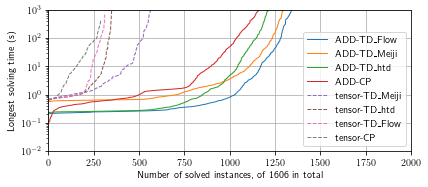

In [143]:
def drawDpmcCurve(ax, table, tag, style=''):
    if not style:
        style = DP_STYLE if getEt(tag) == DMC else VBS_STYLE
    drawSolverCurve(ax, table, tag, label=getDpmcLabel(tag), style=style)

def getMcSolutionFigAx():
    (fig, ax) = getFigAx(
        xMax=2000,
        yMin=1e-2,
        yMax=TIME,
    )
    return (fig, ax)

(fig, ax) = getMcSolutionFigAx()

drawDpmcCurve(ax, R_TABLE, DP_DLF)
drawDpmcCurve(ax, R_TABLE, DP_DLM)
drawDpmcCurve(ax, R_TABLE, DP_DLH)
drawDpmcCurve(ax, R_TABLE, DP_DH)

drawDpmcCurve(ax, R_TABLE, DP_TLM)
drawDpmcCurve(ax, R_TABLE, DP_TLH)
drawDpmcCurve(ax, R_TABLE, DP_TLF)
drawDpmcCurve(ax, R_TABLE, DP_TH)

# drawVbsCurve(ax, R_TABLE, R_TABLE.getTags(), 'VBS', ':')

# writeFig(fig, 'r/combos/first_tw100.pgf')

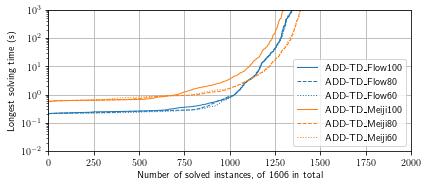

In [144]:
colorInd = 0
def drawTwCurve(ax, table, tag, style='-'):
    global colorInd
    if getTd(tag) == MEIJI and not tag.endswith('0'):
        colorInd += 1
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][colorInd]
    drawSolverCurve(ax, table, tag, label=getTwLabel(tag), style=style, color=color)

(fig, ax) = getMcSolutionFigAx()

drawTwCurve(ax, R_TABLE, DP_DLF)
drawTwCurve(ax, R_TABLE, DP_DLF80, style='--')
drawTwCurve(ax, R_TABLE, DP_DLF60, style=':')
# drawTwCurve(ax, R_TABLE, DP_DLF40, style=':')

drawTwCurve(ax, R_TABLE, DP_DLM)
drawTwCurve(ax, R_TABLE, DP_DLM80, style='--')
drawTwCurve(ax, R_TABLE, DP_DLM60, style=':')
# drawTwCurve(ax, R_TABLE, DP_DLM40, style=':')

# writeFig(fig, 'r/combos/first_tws.pgf')

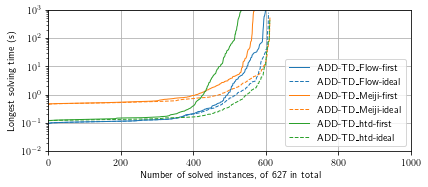

In [145]:
colorInd = -1
def drawExecCurve(ax, table, tag):
    global colorInd
    if getPt(tag) == LG:
        if getIdealJtFlag(tag):
            style = '--'
        else:
            style = '-'
            colorInd += 1
    else:
        style = ':'
        colorInd += 1
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][colorInd]
    drawSolverCurve(ax, table, tag, label=getExecLabel(tag), style=style, color=color)

(fig, ax) = getFigAx(
    xMax=1000,
    yMin=1e-2,
    yMax=TIME,
)

drawExecCurve(ax, EXEC_TABLE, DLF0)
drawExecCurve(ax, EXEC_TABLE, DLF1)
drawExecCurve(ax, EXEC_TABLE, DLM0)
drawExecCurve(ax, EXEC_TABLE, DLM1)
drawExecCurve(ax, EXEC_TABLE, DLH0)
drawExecCurve(ax, EXEC_TABLE, DLH1)
# drawExecCurve(ax, EXEC_TABLE, DH)
# drawExecCurve(ax, EXEC_TABLE, TLF0)
# drawExecCurve(ax, EXEC_TABLE, TLF1)
# drawExecCurve(ax, EXEC_TABLE, TLM0)
# drawExecCurve(ax, EXEC_TABLE, TLM1)
# drawExecCurve(ax, EXEC_TABLE, TLH0)
# drawExecCurve(ax, EXEC_TABLE, TLH1)
# drawExecCurve(ax, EXEC_TABLE, TH)

# writeFig(fig, 'r/combos/ideal.pgf')

#### Solvers

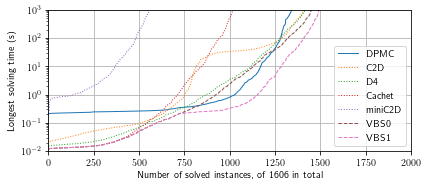

In [146]:
(fig, ax) = getMcSolutionFigAx()

drawSolverCurve(ax, R_TABLE, DP_DLF)

drawSolverCurve(ax, R_TABLE, C2D)
drawSolverCurve(ax, R_TABLE, D4)
drawSolverCurve(ax, R_TABLE, CAC)
drawSolverCurve(ax, R_TABLE, MINI)

drawVbsCurve(ax, R_TABLE, {CAC, C2D, MINI, D4})
drawVbsCurve(ax, R_TABLE, {CAC, C2D, MINI, D4,
    DP_DLF,
#     DP_DLM,
#     DP_DLH,
#     DP_DH,
})

# writeFig(fig, 'r/solvers.pgf')

### Widths

#### Distro

In [147]:
R_TABLE['width'].describe()

count    1520.000000
mean       35.425000
std        18.027071
min         4.000000
25%        24.000000
50%        31.000000
75%        44.000000
max       100.000000
Name: width, dtype: float64

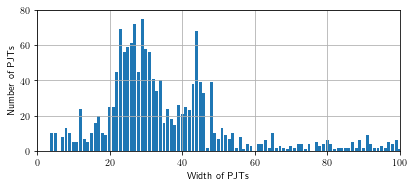

In [148]:
def drawWidths(table, ax):
    widths = list(filter(pd.notnull, table['width']))
    ax.bar(*zip(*Counter(widths).items()))
    ax.set_xlabel('Width of PJTs')
    ax.set_ylabel('Number of PJTs')
    ax.grid(True)

(fig, ax) = getFigAx(
#     xMin=4,
    xMax=100,
    yMax=80,
)

drawWidths(R_TABLE, ax)

# writeFig(fig, 'r/widths.pgf')

#### PAR-2 scores

In [149]:
MC_SCORES = getScoresByWidthDictByTag(R_TABLE, tags={DP_DLF, CAC, C2D, MINI, D4}, verbTags=set([
#     MINI,
]))

1520 PJTs for 1606 formulas (94%) of widths 4--100


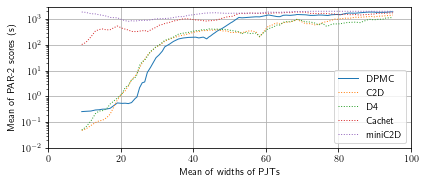

In [150]:
def getMcFigAx():
    return getFigAx(
        xMax=100,
        yMin=1e-2,
        yMax=TIME * 3,
    )

(fig, ax) = getMcFigAx()

drawMeanCurve(ax, MC_SCORES, DP_DLF)
drawMeanCurve(ax, MC_SCORES, C2D)
drawMeanCurve(ax, MC_SCORES, D4)
drawMeanCurve(ax, MC_SCORES, CAC)
drawMeanCurve(ax, MC_SCORES, MINI)

# writeFig(fig, 'r/scores/means.pgf')

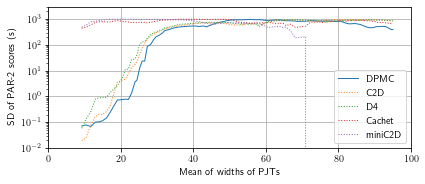

In [151]:
(fig, ax) = getMcFigAx()

drawDevCurve(ax, MC_SCORES, DP_DLF)
drawDevCurve(ax, MC_SCORES, C2D)
drawDevCurve(ax, MC_SCORES, D4)
drawDevCurve(ax, MC_SCORES, CAC)
drawDevCurve(ax, MC_SCORES, MINI)

# writeFig(fig, 'r/scores/devs.pgf')

## E-SAT

### Application

#### Solutions

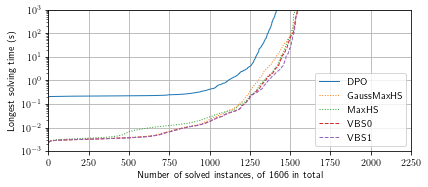

In [152]:
(fig, ax) = getFigAx(
    xMax=2250,
    yMin=1e-3,
    yMax=TIME,
)

drawSolverCurve(ax, APP_E_TABLE, DPO)
drawSolverCurve(ax, APP_E_TABLE, GAU)
drawSolverCurve(ax, APP_E_TABLE, MAX)

drawVbsCurve(ax, APP_E_TABLE, {GAU, MAX})
drawVbsCurve(ax, APP_E_TABLE, {GAU, MAX, DPO})

# writeFig(fig, 'e/app/solvers.pgf')

#### Widths

1520 PJTs for 1606 formulas (94%) of widths 4--100


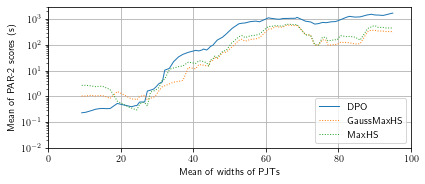

In [153]:
APP_E_SCORES = getScoresByWidthDictByTag(APP_E_TABLE)

def getAppWsatFigAx():
    return getFigAx(
        xMax=100,
        yMin=1e-2,
        yMax=TIME * 3,
    )

(fig, ax) = getAppWsatFigAx()

drawMeanCurve(ax, APP_E_SCORES, DPO)
drawMeanCurve(ax, APP_E_SCORES, GAU)
drawMeanCurve(ax, APP_E_SCORES, MAX)

# writeFig(fig, 'e/app/scores/means.pgf')

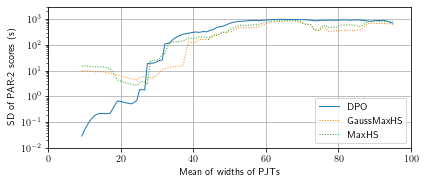

In [154]:
(fig, ax) = getAppWsatFigAx()

drawDevCurve(ax, APP_E_SCORES, DPO)
drawDevCurve(ax, APP_E_SCORES, GAU)
drawDevCurve(ax, APP_E_SCORES, MAX)

# writeFig(fig, 'e/app/scores/devs.pgf')

### Chain

#### Solutions

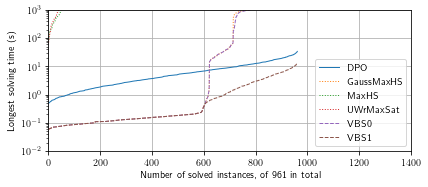

In [155]:
(fig, ax) = getFigAx(
    xMax=1400,
    yMin=1e-2,
    yMax=TIME,
)

drawSolverCurve(ax, CHAIN_E_TABLE, DPO)
drawSolverCurve(ax, CHAIN_E_TABLE, GAU)
drawSolverCurve(ax, CHAIN_E_TABLE, MAX)
drawSolverCurve(ax, CHAIN_E_TABLE, UWR)

drawVbsCurve(ax, CHAIN_E_TABLE, {GAU, MAX, UWR})
drawVbsCurve(ax, CHAIN_E_TABLE, {GAU, MAX, UWR, DPO})

# writeFig(fig, 'e/chain/solvers.pgf')

#### Widths

In [156]:
# setMaxRows(970)

df = CHAIN_DPO_INST.getDf('select file,width,time from data where width order by width')

df = df.merge(CHAIN_GAU_INST.getDf('select file,time from data'))
# df = df.merge(CHAIN_MAX_INST.getDf('select file,time from data where time < 1000'))
# df = df.merge(CHAIN_UWR_INST.getDf('select file,time from data where time < 1000'))

df

,file,width,timeDpo,timeGau
0,0,10,0.514516,16.883800
1,1,10,0.526332,28.284200
2,2,10,0.542999,34.980400
3,3,10,0.490488,49.510900
4,4,10,0.550117,55.243500
...,...,...,...,...
956,956,40,27.699700,0.197355
957,957,40,28.962900,0.190810
958,958,40,30.305700,0.193886
959,959,40,33.560100,0.233590


961 PJTs for 961 formulas (100%) of widths 10--40


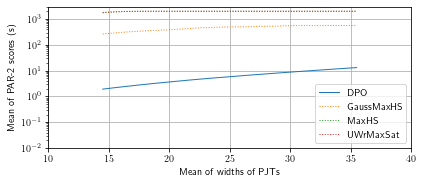

In [157]:
# setMaxRows()

CHAIN_E_SCORES = getScoresByWidthDictByTag(CHAIN_E_TABLE)

def getChainWsatFigAx():
    return getFigAx(
        xMin=10,
        xMax=40,
        yMin=1e-2,
        yMax=TIME * 3,
    )

(fig, ax) = getChainWsatFigAx()

drawMeanCurve(ax, CHAIN_E_SCORES, DPO)
drawMeanCurve(ax, CHAIN_E_SCORES, GAU)
drawMeanCurve(ax, CHAIN_E_SCORES, MAX)
drawMeanCurve(ax, CHAIN_E_SCORES, UWR)

# writeFig(fig, 'e/chain/scores/means.pgf')

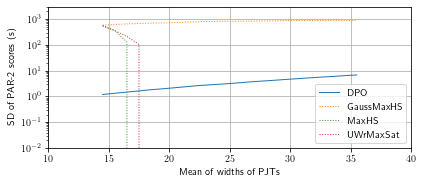

In [158]:
(fig, ax) = getChainWsatFigAx()

drawDevCurve(ax, CHAIN_E_SCORES, DPO)
drawDevCurve(ax, CHAIN_E_SCORES, GAU)
drawDevCurve(ax, CHAIN_E_SCORES, MAX)
drawDevCurve(ax, CHAIN_E_SCORES, UWR)

# writeFig(fig, 'e/chain/scores/devs.pgf')

## RE-SAT

### Solutions

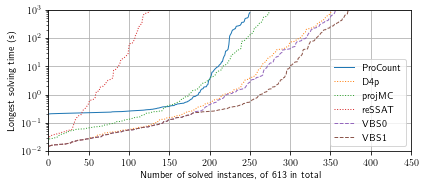

In [159]:
(fig, ax) = getFigAx(
    xMax=450,
    yMin=1e-2,
    yMax=TIME,
)

drawSolverCurve(ax, RE_TABLE, DPRE)

drawSolverCurve(ax, RE_TABLE, D4P)
drawSolverCurve(ax, RE_TABLE, PROJ)
drawSolverCurve(ax, RE_TABLE, RESS)

drawVbsCurve(ax, RE_TABLE, {D4P, PROJ, RESS})
drawVbsCurve(ax, RE_TABLE, {D4P, PROJ, RESS, DPRE})

# writeFig(fig, 're/solvers.pgf')

### Widths

In [160]:
# setMaxRows(50)

q = 'select root,width,time from data'
q += ' where width <= 20'
q += ' order by width'

DPRE_INST.getDf(q).merge(D4P_INST.getDf('select root,time from data'))

,root,width,timeDpre,timeD4p
0,tableBasedAddition.sk_240_1024,1,0.248707,0.050661
1,tutorial1.sk_1_1,1,0.239112,0.045915
2,blasted_case200,7,0.210922,0.017245
3,blasted_case206,7,0.210696,0.015354
4,s27_new_15_7,8,0.268973,0.019316
...,...,...,...,...
39,blasted_case58,20,0.218373,0.018500
40,blasted_case59,20,0.216215,0.016677
41,blasted_case59_1,20,0.214017,0.023013
42,blasted_case63,20,0.217676,0.017493


In [161]:
# setMaxRows()

RE_SCORES = getScoresByWidthDictByTag(RE_TABLE, verbTags=set([
#     DPRE,
]))

281 PJTs for 613 formulas (45%) of widths 1--138


In [162]:
q = 'select file,root,vars,show,width,time from data'
q += ' where width = 48'
q += ' or width = 59'
q += ' order by width,time'

DPRE_INST.ask(q)

,file,root,vars,show,width,time
0,319,blasted_case_2_b14_2,270,43,48,0.278774
1,326,blasted_case_3_b14_2,270,43,48,0.301599
2,309,blasted_case_1_b14_2,270,43,48,0.483553
3,475,min-3s,366,64,48,18.974800
4,464,min-16s,1992,272,48,133.292000
5,474,min-32s,4056,528,48,265.208000
6,471,min-28s,3468,464,48,307.530000
7,593,s641_7_4,507,54,59,0.256225
8,580,s510_3_2,298,25,59,0.280302
9,128,53.sk_4_32,2581,32,59,0.951829


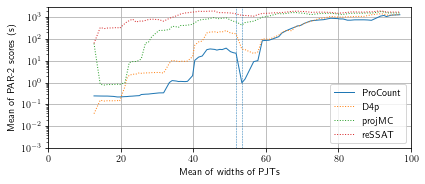

In [163]:
def getReFigAx():
    return getFigAx(
        xMax=100,
        yMin=1e-3,
        yMax=TIME * 3,
    )

(fig, ax) = getReFigAx()

drawLine(ax, 51.8)
drawLine(ax, 53.4)

drawMeanCurve(ax, RE_SCORES, DPRE)
drawMeanCurve(ax, RE_SCORES, D4P)
drawMeanCurve(ax, RE_SCORES, PROJ)
drawMeanCurve(ax, RE_SCORES, RESS)

# writeFig(fig, 're/scores/means.pgf')

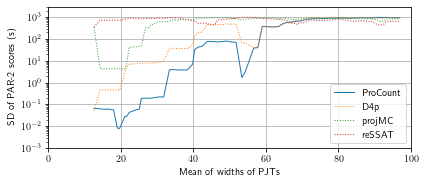

In [164]:
(fig, ax) = getReFigAx()

drawDevCurve(ax, RE_SCORES, DPRE)
drawDevCurve(ax, RE_SCORES, D4P)
drawDevCurve(ax, RE_SCORES, PROJ)
drawDevCurve(ax, RE_SCORES, RESS)

# writeFig(fig, 're/scores/devs.pgf')

## ER-SAT

### Solutions

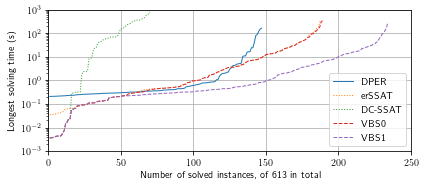

In [165]:
(fig, ax) = getFigAx(
    xMax=250,
    yMin=1e-3,
    yMax=TIME,
)

drawSolverCurve(ax, ER_TABLE, DPER)

drawSolverCurve(ax, ER_TABLE, ERSS)
drawSolverCurve(ax, ER_TABLE, DCSS)

drawVbsCurve(ax, ER_TABLE, {ERSS, DCSS})
drawVbsCurve(ax, ER_TABLE, {ERSS, DCSS, DPER})

# writeFig(fig, 'er/solvers.pgf')

### Widths

In [166]:
ER_SCORES = getScoresByWidthDictByTag(ER_TABLE, verbTags=set([
#     DPER,
#     ERSS,
]))

204 PJTs for 613 formulas (33%) of widths 1--244


In [167]:
# setMaxRows(210)

q = 'select file,root,width,time,timeout from data'
q += ' where width'
q += ' order by width'

DPER_INST.ask(q)

,file,root,width,time,timeout
0,496,tableBasedAddition.sk_240_1024,1,0.307916,0
1,497,tutorial1.sk_1_1,1,0.256769,0
2,540,s27_15_7,4,0.297739,0
3,541,s27_3_2,4,0.282178,0
4,542,s27_7_4,4,0.276582,0
...,...,...,...,...,...
199,182,blasted_case110,225,1010.060000,1
200,183,blasted_case111,243,1010.050000,1
201,185,blasted_case113,244,1010.060000,1
202,189,blasted_case117,244,1010.050000,1


In [168]:
# setMaxRows()

df = DPER_INST.getDf('select file,root,width from data where width > 100 order by width')
df = df.merge(ERSS_INST.getDf('select root,sol,time from data '))
df

,file,root,width,solErss,timeErss
0,211,blasted_case14,106,NaN,1010.040000
1,204,blasted_case133,109,0.000000e+00,0.043970
2,207,blasted_case136,109,0.000000e+00,0.117091
3,292,blasted_case9,110,NaN,1010.080000
4,475,min-3s,115,NaN,1010.070000
5,222,blasted_case19,116,0.000000e+00,8.093840
6,225,blasted_case20,116,0.000000e+00,0.916789
7,219,blasted_case15,121,NaN,1010.070000
8,203,blasted_case132,123,0.000000e+00,0.110160
9,206,blasted_case135,123,0.000000e+00,0.116542


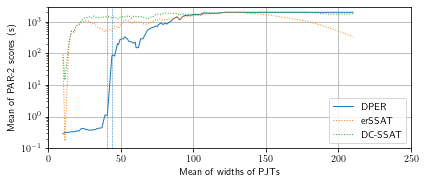

In [169]:
yMax = TIME * 3

def getErFigAx():
    return getFigAx(
        xMax=250,
        yMin=1e-1,
        yMax=yMax,
    )

(fig, ax) = getErFigAx()

drawLine(ax, 40.7)
drawLine(ax, 43.8)

drawMeanCurve(ax, ER_SCORES, DPER)
drawMeanCurve(ax, ER_SCORES, ERSS)
drawMeanCurve(ax, ER_SCORES, DCSS)

# writeFig(fig, 'er/scores/means.pgf')

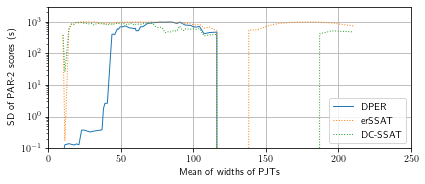

In [170]:
(fig, ax) = getErFigAx()

drawDevCurve(ax, ER_SCORES, DPER)
drawDevCurve(ax, ER_SCORES, ERSS)
drawDevCurve(ax, ER_SCORES, DCSS)

# writeFig(fig, 'er/scores/devs.pgf')